In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames[:3]:
        print(os.path.join(dirname, filename))
    if len(filenames) > 3:
        print("...")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./dataset\sample_submission.csv
./dataset\test\task1\005dYEOeB8KTDJV7.png
./dataset\test\task1\01AJuSTVpsv0KV1e.png
./dataset\test\task1\01WxCUVvVoBaRzSy.png
...
./dataset\test\task2\02ZHnWOurKjQ4gKF.png
./dataset\test\task2\04RCLLErB2K1nSu0.png
./dataset\test\task2\04WTOdAEboG3P76U.png
...
./dataset\test\task3\01zd7u2yLj8q39TR.png
./dataset\test\task3\04U4SuyMUrn9TS7i.png
./dataset\test\task3\0803j2KBz4fYAEZh.png
...
./dataset\train\annotations.csv
./dataset\train\task1\00Hmj4szDc3YLT5G.png
./dataset\train\task1\01G2Mu4m4I4xdNoQ.png
./dataset\train\task1\01tqaXj8FODGc92T.png
...
./dataset\train\task2\00FI6dtTyVDXlkD5.png
./dataset\train\task2\01OowdncmXLncJxu.png
./dataset\train\task2\02kdGzYrgFyzIK8P.png
...
./dataset\train\task3\00wbmgWGL1RWVek2.png
./dataset\train\task3\016OMGaoqyht3FHe.png
./dataset\train\task3\01AFsTotCZNTzlSh.png
...


In [2]:
import csv
import cv2
import numpy as np
import random
import os
import glob

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.jit
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary

C:\Users\user\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
TRAIN_PATH = "./dataset/train"
TEST_PATH = "./dataset/test"
# device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device = "cuda"
# try device = "cuda" 
# and change your settings/accelerator to GPU if you want it to run faster if your using kaggle's enviroment

In [5]:
alphabets = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
alphabets2index = {alphabet:i for i, alphabet in enumerate(alphabets)}


In [6]:
class Task1Dataset(Dataset):
    def __init__(self, data, root, return_filename=False):
        self.data = [sample for sample in data if sample[0].startswith("task1")]
        self.return_filename = return_filename
        self.root = root
        self.transform = transforms.Compose([
            #transforms.Resize(32),
            transforms.RandomRotation(degrees=20),
            transforms.ToTensor()
        ])
    
    def __getitem__(self, index):
        filename, label = self.data[index]
        img = cv2.imread("{}/{}".format(self.root, filename))
        img = cv2.resize(img, (96, 96))
        img = cv2.medianBlur(img, 5)
        img = np.mean(img, axis=2)
        img = Image.fromarray(img)
        img = self.transform(img)
        
        if self.return_filename:
            return torch.FloatTensor((img - 128) / 128), filename
        else:
            return torch.FloatTensor((img - 128) / 128), alphabets2index[label]

    def __len__(self):
        return len(self.data)


In [6]:
def downsample(in_ch, out_ch, stride):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=(1, 1), stride=stride, bias=False),
        nn.BatchNorm2d(out_ch))

class BasicBlock(nn.Module):
    '''
    input -> con2d(3x3) -> BN -> activation -> con2d(3x3) -> BN -> activation -> output
    Perform downsampling directly by convolutional layers that have a stride of 2
    '''
    def __init__(self, in_ch, out_ch, downsample_stride):
        super(BasicBlock, self).__init__()
        if downsample_stride is None:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            self.downsample = None
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.downsample = downsample(in_ch, out_ch, downsample_stride)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        ori = x
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            ori = self.downsample(ori)
        out = self.relu(out+ori)
        return out

In [8]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64, None),
            BasicBlock(64, 64, None)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, (2, 2)),
            BasicBlock(128, 128, None)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, (2, 2)),
            BasicBlock(256, 256, None)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, (2, 2)),
            BasicBlock(512, 512, None)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, len(alphabets))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = self.fc(out.reshape(out.shape[0], -1))
        return out

In [9]:
train_data = []
val_data = []

with open('{}/annotations.csv'.format(TRAIN_PATH), newline='') as csvfile:
    for row in csv.reader(csvfile, delimiter=','):
        if random.random() < 0.8:
            train_data.append(row)
        else:
            val_data.append(row)

train_ds = Task1Dataset(train_data, root=TRAIN_PATH)
train_dl = DataLoader(train_ds, batch_size=32, num_workers=0, drop_last=True, shuffle=True)

val_ds = Task1Dataset(val_data, root=TRAIN_PATH)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0, drop_last=False, shuffle=False)

In [10]:
model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-03)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
epoch = 100

cpt_dir = './model_weights/'
os.makedirs(cpt_dir, exist_ok=True)
phase_dir = './results/'
os.makedirs(phase_dir, exist_ok=True)

In [11]:
summary(model, input_size=(1, 96, 96), batch_size = 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 48, 48]           3,136
       BatchNorm2d-2           [32, 64, 48, 48]             128
              ReLU-3           [32, 64, 48, 48]               0
         MaxPool2d-4           [32, 64, 24, 24]               0
            Conv2d-5           [32, 64, 24, 24]          36,864
       BatchNorm2d-6           [32, 64, 24, 24]             128
              ReLU-7           [32, 64, 24, 24]               0
            Conv2d-8           [32, 64, 24, 24]          36,864
       BatchNorm2d-9           [32, 64, 24, 24]             128
             ReLU-10           [32, 64, 24, 24]               0
       BasicBlock-11           [32, 64, 24, 24]               0
           Conv2d-12           [32, 64, 24, 24]          36,864
      BatchNorm2d-13           [32, 64, 24, 24]             128
             ReLU-14           [32, 64,

In [12]:
# Write the labels of the csv for plotting
headerList = ['Epoch', 'Training accuracy', 'Training loss', 'Validation acurracy', 'Validation loss']

with open('./results/epoch_curve_plotting_data.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerow(headerList)

In [13]:
epoch_pbar = tqdm(range(1, epoch+1))

for epoch in epoch_pbar:
    print("Epoch [{}]".format(epoch))
    
    # save epoch
    epoch_plotting_data = []
    epoch_plotting_data.append(epoch)
    
    correct = 0
    sample = 0
    model.train()
    batch_pbar = tqdm(train_dl)
    for batch_idx, (image, label) in enumerate(batch_pbar):
        image = image.to(device)
        label = label.to(device)
        
        pred = model(image)
        loss = loss_fn(pred, label)
        
        pred = torch.argmax(pred, dim=1)
        correct += (pred == label).sum().cpu().item()
        sample += len(image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_plotting_data.append(correct/sample)
    epoch_plotting_data.append(loss.item())
        
    sample_count = 0
    correct_count = 0
    loss = 0
    model.eval()
    batch_pbar = tqdm(val_dl)
    for batch_idx, (image, label) in enumerate(batch_pbar):
        image = image.to(device)
        label = label.to(device)
        
        pred = model(image)
        val_loss = loss_fn(pred, label)
        
        pred = torch.argmax(pred, dim=1)
        
        sample_count += len(image)
        correct_count += (label == pred).sum().cpu().item()
        
        loss += val_loss
    
    scheduler.step()
    
    epoch_plotting_data.append(correct_count/sample_count)
    epoch_plotting_data.append(val_loss.item())
    
    with open('./results/epoch_curve_plotting_data.csv', 'a+', newline ='') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerow(epoch_plotting_data)
    
    torch.save(model.state_dict(), os.path.join(cpt_dir, 'epoch{}.pt'.format(epoch)))
        
    print(" Validation accuracy: {}, loss: {}".format(correct_count / sample_count, loss / sample_count))

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch [1]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:19<00:00,  2.51it/s]

  1%|▊                                                                                 | 1/100 [00:23<38:56, 23.60s/it]

 Validation accuracy: 0.04950495049504951, loss: 0.14560341835021973
Epoch [2]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.78it/s]

  2%|█▋                                                                                | 2/100 [00:31<23:42, 14.51s/it]

 Validation accuracy: 0.07425742574257425, loss: 0.16672161221504211
Epoch [3]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.34it/s]

  3%|██▍                                                                               | 3/100 [00:39<18:22, 11.37s/it]

 Validation accuracy: 0.14108910891089108, loss: 0.11109624803066254
Epoch [4]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.31it/s]

  4%|███▎                                                                              | 4/100 [00:47<15:49,  9.89s/it]

 Validation accuracy: 0.05198019801980198, loss: 0.3461747169494629
Epoch [5]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.14it/s]

  5%|████                                                                              | 5/100 [00:54<14:29,  9.16s/it]

 Validation accuracy: 0.13366336633663367, loss: 0.1474827080965042
Epoch [6]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.20it/s]

  6%|████▉                                                                             | 6/100 [01:02<13:34,  8.67s/it]

 Validation accuracy: 0.4777227722772277, loss: 0.053337182849645615
Epoch [7]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.12it/s]

  7%|█████▋                                                                            | 7/100 [01:10<13:04,  8.44s/it]

 Validation accuracy: 0.3613861386138614, loss: 0.06995530426502228
Epoch [8]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.76it/s]

  8%|██████▌                                                                           | 8/100 [01:18<12:55,  8.43s/it]

 Validation accuracy: 0.6633663366336634, loss: 0.03684540092945099
Epoch [9]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.04it/s]

  9%|███████▍                                                                          | 9/100 [01:28<13:16,  8.75s/it]

 Validation accuracy: 0.5321782178217822, loss: 0.049886833876371384
Epoch [10]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.80it/s]

 10%|████████                                                                         | 10/100 [01:38<13:37,  9.09s/it]

 Validation accuracy: 0.5668316831683168, loss: 0.0382419228553772
Epoch [11]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:09<00:00,  5.09it/s]

 11%|████████▉                                                                        | 11/100 [01:49<14:17,  9.63s/it]

 Validation accuracy: 0.5321782178217822, loss: 0.0510237030684948
Epoch [12]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.73it/s]

 12%|█████████▋                                                                       | 12/100 [01:58<14:10,  9.66s/it]

 Validation accuracy: 0.7202970297029703, loss: 0.028900472447276115
Epoch [13]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.97it/s]

 13%|██████████▌                                                                      | 13/100 [02:08<13:53,  9.58s/it]

 Validation accuracy: 0.39851485148514854, loss: 0.06688595563173294
Epoch [14]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.63it/s]

 14%|███████████▎                                                                     | 14/100 [02:18<13:56,  9.73s/it]

 Validation accuracy: 0.75, loss: 0.026503944769501686
Epoch [15]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.77it/s]

 15%|████████████▏                                                                    | 15/100 [02:28<13:46,  9.72s/it]

 Validation accuracy: 0.650990099009901, loss: 0.035858336836099625
Epoch [16]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.87it/s]

 16%|████████████▉                                                                    | 16/100 [02:37<13:32,  9.68s/it]

 Validation accuracy: 0.594059405940594, loss: 0.03898538649082184
Epoch [17]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.66it/s]

 17%|█████████████▊                                                                   | 17/100 [02:47<13:29,  9.75s/it]

 Validation accuracy: 0.7128712871287128, loss: 0.029793130233883858
Epoch [18]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.19it/s]

 18%|██████████████▌                                                                  | 18/100 [02:56<12:58,  9.49s/it]

 Validation accuracy: 0.8143564356435643, loss: 0.020579177886247635
Epoch [19]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.29it/s]

 19%|███████████████▍                                                                 | 19/100 [03:05<12:36,  9.34s/it]

 Validation accuracy: 0.29207920792079206, loss: 0.08056014776229858
Epoch [20]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.55it/s]

 20%|████████████████▏                                                                | 20/100 [03:15<12:46,  9.58s/it]

 Validation accuracy: 0.745049504950495, loss: 0.02505975216627121
Epoch [21]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.60it/s]

 21%|█████████████████                                                                | 21/100 [03:25<12:47,  9.71s/it]

 Validation accuracy: 0.8044554455445545, loss: 0.021222805604338646
Epoch [22]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.19it/s]

 22%|█████████████████▊                                                               | 22/100 [03:34<12:24,  9.54s/it]

 Validation accuracy: 0.8044554455445545, loss: 0.023259684443473816
Epoch [23]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.88it/s]

 23%|██████████████████▋                                                              | 23/100 [03:42<11:41,  9.11s/it]

 Validation accuracy: 0.8415841584158416, loss: 0.017557568848133087
Epoch [24]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.99it/s]

 24%|███████████████████▍                                                             | 24/100 [03:50<11:06,  8.76s/it]

 Validation accuracy: 0.693069306930693, loss: 0.028763065114617348
Epoch [25]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.46it/s]

 25%|████████████████████▎                                                            | 25/100 [03:59<10:53,  8.71s/it]

 Validation accuracy: 0.2301980198019802, loss: 0.133225679397583
Epoch [26]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.13it/s]

 26%|█████████████████████                                                            | 26/100 [04:07<10:24,  8.44s/it]

 Validation accuracy: 0.693069306930693, loss: 0.03288741409778595
Epoch [27]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.01it/s]

 27%|█████████████████████▊                                                           | 27/100 [04:15<10:05,  8.29s/it]

 Validation accuracy: 0.7524752475247525, loss: 0.024759776890277863
Epoch [28]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.98it/s]

 28%|██████████████████████▋                                                          | 28/100 [04:23<09:51,  8.21s/it]

 Validation accuracy: 0.8564356435643564, loss: 0.016831504181027412
Epoch [29]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.65it/s]

 29%|███████████████████████▍                                                         | 29/100 [04:31<09:53,  8.35s/it]

 Validation accuracy: 0.8316831683168316, loss: 0.018834790214896202
Epoch [30]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.59it/s]

 30%|████████████████████████▎                                                        | 30/100 [04:40<09:45,  8.37s/it]

 Validation accuracy: 0.9331683168316832, loss: 0.010239526629447937
Epoch [31]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.62it/s]

 31%|█████████████████████████                                                        | 31/100 [04:48<09:37,  8.37s/it]

 Validation accuracy: 0.7896039603960396, loss: 0.021151643246412277
Epoch [32]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.83it/s]

 32%|█████████████████████████▉                                                       | 32/100 [04:56<09:25,  8.31s/it]

 Validation accuracy: 0.7747524752475248, loss: 0.024104667827486992
Epoch [33]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.92it/s]

 33%|██████████████████████████▋                                                      | 33/100 [05:04<09:11,  8.23s/it]

 Validation accuracy: 0.7722772277227723, loss: 0.0231953002512455
Epoch [34]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.93it/s]

 34%|███████████████████████████▌                                                     | 34/100 [05:13<09:02,  8.23s/it]

 Validation accuracy: 0.8663366336633663, loss: 0.015926115214824677
Epoch [35]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.93it/s]

 35%|████████████████████████████▎                                                    | 35/100 [05:21<08:50,  8.17s/it]

 Validation accuracy: 0.9306930693069307, loss: 0.011089622043073177
Epoch [36]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.54it/s]

 36%|█████████████████████████████▏                                                   | 36/100 [05:29<08:50,  8.29s/it]

 Validation accuracy: 0.7945544554455446, loss: 0.022700583562254906
Epoch [37]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.48it/s]

 37%|█████████████████████████████▉                                                   | 37/100 [05:38<08:51,  8.44s/it]

 Validation accuracy: 0.8292079207920792, loss: 0.018909858539700508
Epoch [38]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.72it/s]

 38%|██████████████████████████████▊                                                  | 38/100 [05:46<08:40,  8.40s/it]

 Validation accuracy: 0.8539603960396039, loss: 0.015599999576807022
Epoch [39]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.89it/s]

 39%|███████████████████████████████▌                                                 | 39/100 [05:54<08:26,  8.31s/it]

 Validation accuracy: 0.8985148514851485, loss: 0.013568314723670483
Epoch [40]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.79it/s]

 40%|████████████████████████████████▍                                                | 40/100 [06:03<08:16,  8.28s/it]

 Validation accuracy: 0.7920792079207921, loss: 0.021749090403318405
Epoch [41]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.84it/s]

 41%|█████████████████████████████████▏                                               | 41/100 [06:11<08:05,  8.23s/it]

 Validation accuracy: 0.1608910891089109, loss: 0.18716295063495636
Epoch [42]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.86it/s]

 42%|██████████████████████████████████                                               | 42/100 [06:19<07:55,  8.20s/it]

 Validation accuracy: 0.905940594059406, loss: 0.010406559333205223
Epoch [43]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.82it/s]

 43%|██████████████████████████████████▊                                              | 43/100 [06:27<07:47,  8.20s/it]

 Validation accuracy: 0.8737623762376238, loss: 0.013912769965827465
Epoch [44]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.93it/s]

 44%|███████████████████████████████████▋                                             | 44/100 [06:35<07:37,  8.16s/it]

 Validation accuracy: 0.8836633663366337, loss: 0.012348468415439129
Epoch [45]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.87it/s]

 45%|████████████████████████████████████▍                                            | 45/100 [06:43<07:27,  8.14s/it]

 Validation accuracy: 0.849009900990099, loss: 0.016066910699009895
Epoch [46]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.42it/s]

 46%|█████████████████████████████████████▎                                           | 46/100 [06:52<07:27,  8.29s/it]

 Validation accuracy: 0.8886138613861386, loss: 0.014578011818230152
Epoch [47]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.86it/s]

 47%|██████████████████████████████████████                                           | 47/100 [07:00<07:16,  8.24s/it]

 Validation accuracy: 0.948019801980198, loss: 0.008193690329790115
Epoch [48]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.87it/s]

 48%|██████████████████████████████████████▉                                          | 48/100 [07:08<07:06,  8.20s/it]

 Validation accuracy: 0.943069306930693, loss: 0.008671686984598637
Epoch [49]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.90it/s]

 49%|███████████████████████████████████████▋                                         | 49/100 [07:16<06:56,  8.17s/it]

 Validation accuracy: 0.8391089108910891, loss: 0.01849539391696453
Epoch [50]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.76it/s]

 50%|████████████████████████████████████████▌                                        | 50/100 [07:24<06:49,  8.18s/it]

 Validation accuracy: 0.8985148514851485, loss: 0.011658193543553352
Epoch [51]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.60it/s]

 51%|█████████████████████████████████████████▎                                       | 51/100 [07:33<06:45,  8.27s/it]

 Validation accuracy: 0.9108910891089109, loss: 0.011418657377362251
Epoch [52]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.79it/s]

 52%|██████████████████████████████████████████                                       | 52/100 [07:41<06:35,  8.24s/it]

 Validation accuracy: 0.8094059405940595, loss: 0.022816680371761322
Epoch [53]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.55it/s]

 53%|██████████████████████████████████████████▉                                      | 53/100 [07:50<06:31,  8.33s/it]

 Validation accuracy: 0.9405940594059405, loss: 0.007148277014493942
Epoch [54]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.08it/s]

 54%|███████████████████████████████████████████▋                                     | 54/100 [07:59<06:32,  8.54s/it]

 Validation accuracy: 0.8712871287128713, loss: 0.013060326687991619
Epoch [55]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.13it/s]

 55%|████████████████████████████████████████████▌                                    | 55/100 [08:06<06:14,  8.32s/it]

 Validation accuracy: 0.8663366336633663, loss: 0.014980851672589779
Epoch [56]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.08it/s]

 56%|█████████████████████████████████████████████▎                                   | 56/100 [08:14<06:00,  8.18s/it]

 Validation accuracy: 0.9158415841584159, loss: 0.01036078855395317
Epoch [57]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.11it/s]

 57%|██████████████████████████████████████████████▏                                  | 57/100 [08:22<05:47,  8.08s/it]

 Validation accuracy: 0.9282178217821783, loss: 0.008939402177929878
Epoch [58]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.13it/s]

 58%|██████████████████████████████████████████████▉                                  | 58/100 [08:30<05:36,  8.00s/it]

 Validation accuracy: 0.905940594059406, loss: 0.011643295176327229
Epoch [59]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.11it/s]

 59%|███████████████████████████████████████████████▊                                 | 59/100 [08:38<05:26,  7.95s/it]

 Validation accuracy: 0.11138613861386139, loss: 0.17733214795589447
Epoch [60]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.89it/s]

 60%|████████████████████████████████████████████████▌                                | 60/100 [08:46<05:23,  8.08s/it]

 Validation accuracy: 0.9108910891089109, loss: 0.010015963576734066
Epoch [61]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.55it/s]

 61%|█████████████████████████████████████████████████▍                               | 61/100 [08:55<05:19,  8.20s/it]

 Validation accuracy: 0.9183168316831684, loss: 0.008766966871917248
Epoch [62]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.67it/s]

 62%|██████████████████████████████████████████████████▏                              | 62/100 [09:04<05:27,  8.62s/it]

 Validation accuracy: 0.948019801980198, loss: 0.007211260963231325
Epoch [63]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.44it/s]

 63%|███████████████████████████████████████████████████                              | 63/100 [09:13<05:20,  8.67s/it]

 Validation accuracy: 0.9405940594059405, loss: 0.007834848947823048
Epoch [64]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.03it/s]

 64%|███████████████████████████████████████████████████▊                             | 64/100 [09:21<05:03,  8.44s/it]

 Validation accuracy: 0.9133663366336634, loss: 0.011801309883594513
Epoch [65]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.36it/s]

 65%|████████████████████████████████████████████████████▋                            | 65/100 [09:30<04:58,  8.54s/it]

 Validation accuracy: 0.9133663366336634, loss: 0.010016746819019318
Epoch [66]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.65it/s]

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [09:38<04:48,  8.47s/it]

 Validation accuracy: 0.9752475247524752, loss: 0.0056966328993439674
Epoch [67]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.27it/s]

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [09:46<04:31,  8.23s/it]

 Validation accuracy: 0.8663366336633663, loss: 0.014219870790839195
Epoch [68]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.34it/s]

 68%|███████████████████████████████████████████████████████                          | 68/100 [09:53<04:16,  8.03s/it]

 Validation accuracy: 0.9306930693069307, loss: 0.008349087089300156
Epoch [69]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.22it/s]

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [10:01<04:05,  7.93s/it]

 Validation accuracy: 0.8886138613861386, loss: 0.013309192843735218
Epoch [70]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.19it/s]

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [10:10<04:06,  8.21s/it]

 Validation accuracy: 0.9158415841584159, loss: 0.010198919102549553
Epoch [71]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.72it/s]

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [10:18<03:58,  8.23s/it]

 Validation accuracy: 0.943069306930693, loss: 0.007378856185823679
Epoch [72]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.98it/s]

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [10:26<03:48,  8.17s/it]

 Validation accuracy: 0.9183168316831684, loss: 0.008642434142529964
Epoch [73]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.99it/s]

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [10:34<03:38,  8.11s/it]

 Validation accuracy: 0.9331683168316832, loss: 0.008240926079452038
Epoch [74]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.70it/s]

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [10:42<03:32,  8.19s/it]

 Validation accuracy: 0.9603960396039604, loss: 0.005461432505398989
Epoch [75]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.35it/s]

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [10:51<03:29,  8.36s/it]

 Validation accuracy: 0.9455445544554455, loss: 0.007901820354163647
Epoch [76]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.18it/s]

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [11:00<03:25,  8.55s/it]

 Validation accuracy: 0.943069306930693, loss: 0.0068685924634337425
Epoch [77]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.71it/s]

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [11:08<03:15,  8.48s/it]

 Validation accuracy: 0.8910891089108911, loss: 0.011752689257264137
Epoch [78]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.26it/s]

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [11:17<03:08,  8.58s/it]

 Validation accuracy: 0.9752475247524752, loss: 0.004085672553628683
Epoch [79]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.50it/s]

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [11:26<03:01,  8.64s/it]

 Validation accuracy: 0.9405940594059405, loss: 0.008002914488315582
Epoch [80]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.09it/s]

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [11:35<02:55,  8.78s/it]

 Validation accuracy: 0.8836633663366337, loss: 0.015454123727977276
Epoch [81]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.80it/s]

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [11:43<02:43,  8.60s/it]

 Validation accuracy: 0.9554455445544554, loss: 0.00542062520980835
Epoch [82]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.84it/s]

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [11:51<02:32,  8.47s/it]

 Validation accuracy: 0.9356435643564357, loss: 0.008892982266843319
Epoch [83]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.66it/s]

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [12:00<02:23,  8.46s/it]

 Validation accuracy: 0.9603960396039604, loss: 0.004539621062576771
Epoch [84]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.08it/s]

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [12:09<02:18,  8.69s/it]

 Validation accuracy: 0.948019801980198, loss: 0.007230376824736595
Epoch [85]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.28it/s]

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [12:18<02:10,  8.73s/it]

 Validation accuracy: 0.9529702970297029, loss: 0.007431805599480867
Epoch [86]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.86it/s]

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [12:26<01:59,  8.54s/it]

 Validation accuracy: 0.9331683168316832, loss: 0.00784819945693016
Epoch [87]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.03it/s]

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [12:34<01:48,  8.36s/it]

 Validation accuracy: 0.9331683168316832, loss: 0.00828696321696043
Epoch [88]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.99it/s]

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [12:42<01:39,  8.26s/it]

 Validation accuracy: 0.9529702970297029, loss: 0.007891255430877209
Epoch [89]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.98it/s]

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [12:50<01:29,  8.16s/it]

 Validation accuracy: 0.9678217821782178, loss: 0.005348940379917622
Epoch [90]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.97it/s]

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [12:58<01:21,  8.12s/it]

 Validation accuracy: 0.9504950495049505, loss: 0.006010094191879034
Epoch [91]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.93it/s]

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [13:06<01:12,  8.10s/it]

 Validation accuracy: 0.9579207920792079, loss: 0.005979176610708237
Epoch [92]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [13:14<01:04,  8.04s/it]

 Validation accuracy: 0.9579207920792079, loss: 0.005168794188648462
Epoch [93]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [13:22<00:56,  8.04s/it]

 Validation accuracy: 0.9529702970297029, loss: 0.0067587364464998245
Epoch [94]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  6.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [13:31<00:50,  8.34s/it]

 Validation accuracy: 0.9653465346534653, loss: 0.004051990807056427
Epoch [95]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [13:39<00:41,  8.33s/it]

 Validation accuracy: 0.9554455445544554, loss: 0.007145233452320099
Epoch [96]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.70it/s]

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [13:48<00:33,  8.31s/it]

 Validation accuracy: 0.9455445544554455, loss: 0.006989399902522564
Epoch [97]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.91it/s]

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [13:56<00:24,  8.28s/it]

 Validation accuracy: 0.9504950495049505, loss: 0.006850232370197773
Epoch [98]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [14:04<00:16,  8.39s/it]

 Validation accuracy: 0.9554455445544554, loss: 0.006358654238283634
Epoch [99]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.36it/s]

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [14:13<00:08,  8.50s/it]

 Validation accuracy: 0.9653465346534653, loss: 0.005694795399904251
Epoch [100]



100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:23<00:00,  8.63s/it]

 Validation accuracy: 0.9653465346534653, loss: 0.005197977181524038


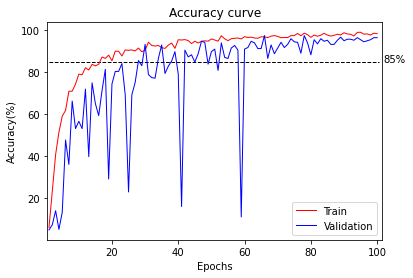

In [15]:
epoch = []
train_acc = []
val_acc = []
train_loss = []
val_loss = []

with open('./results/epoch_curve_plotting_data.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines, None)
    for row in lines:
        epoch.append(int(row[0]))
        train_acc.append(float(row[1])*100)
        train_loss.append(float(row[2]))
        val_acc.append(float(row[3])*100)
        val_loss.append(float(row[4]))

# plt accuracy curve
plt.figure()

plt.plot([1, 100.5], [85, 85], color='black', linestyle='dashed', lw=1)
plt.gca().text(102, 85, '85%', color='black')

plt.plot(epoch, train_acc, color = 'red', linewidth = '1', label = 'Train')
plt.plot(epoch, val_acc, color = 'blue', linewidth = '1', label = 'Validation')

plt.xlim(0.5, 101.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.title('Accuracy curve')
plt.legend(loc='lower right')

plt.savefig('./plots/acc_comparison(ResNet18)_3.png')
plt.show()

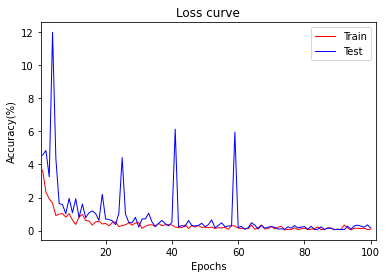

In [16]:
# plt loss curve
plt.figure()

plt.plot(epoch, train_loss, color = 'red', linewidth = '1', label = 'Train')
plt.plot(epoch, val_loss, color = 'blue', linewidth = '1', label = 'Test')

plt.xlim(0.5, 101.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.title('Loss curve')
plt.legend(loc='upper right')

plt.savefig('./plots/loss_comparison(ResNet18)_3.png')
plt.show()

Task 2

In [19]:
class Task2Dataset(Dataset):
    def __init__(self, data, root, return_filename=False):
        self.data = [sample for sample in data if sample[0].startswith("task2")]
        self.return_filename = return_filename
        self.root = root
        self.transform = transforms.Compose([
            #transforms.Resize(32),
            transforms.RandomRotation(degrees=20),
            transforms.ToTensor()
        ])
    
    def __getitem__(self, index):
        filename, label = self.data[index]
        img = cv2.imread("{}/{}".format(self.root, filename))
        img = cv2.resize(img, (96, 96))
        img = cv2.medianBlur(img, 5)
        img = np.mean(img, axis=2)
        img = Image.fromarray(img)
        img = self.transform(img)
        
        label_list = [[alphabets2index[digit]] for digit in label]
        label_list = np.array(label_list)
        #print(label_list)
        
        length = [len(label_list)]
        
        #label_list = [length] + label_list
        label_list = np.append([length], label_list, axis=0)
        
        if self.return_filename:
            return torch.FloatTensor((img - 128) / 128), filename
        else:
            return torch.FloatTensor((img - 128) / 128), label_list

    def __len__(self):
        return len(self.data)

In [20]:
train_data = []
val_data = []

with open('{}/annotations.csv'.format(TRAIN_PATH), newline='') as csvfile:
    for row in csv.reader(csvfile, delimiter=','):
        if random.random() < 0.8:
            train_data.append(row)
        else:
            val_data.append(row)

train_ds = Task2Dataset(train_data, root=TRAIN_PATH)
train_dl = DataLoader(train_ds, batch_size=32, num_workers=0, drop_last=True, shuffle=True)

val_ds = Task2Dataset(val_data, root=TRAIN_PATH)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0, drop_last=False, shuffle=False)

In [21]:
class ResNet18_t2(nn.Module):
    def __init__(self):
        super(ResNet18_t2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64, None),
            BasicBlock(64, 64, None)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, (2, 2)),
            BasicBlock(128, 128, None)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, (2, 2)),
            BasicBlock(256, 256, None)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, (2, 2)),
            BasicBlock(512, 512, None)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.digitlength = nn.Linear(512, 1)
        self.digit1 = nn.Linear(512, len(alphabets))
        self.digit2 = nn.Linear(512, len(alphabets))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        yl = self.digitlength(out.reshape(out.shape[0], -1))
        y1 = self.digit1(out.reshape(out.shape[0], -1))
        y2 = self.digit2(out.reshape(out.shape[0], -1))
        return [yl, y1, y2]

In [22]:
model = ResNet18_t2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-03)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=30, gamma=0.9)
epoch = 250

cpt_dir = './model_weights/'
os.makedirs(cpt_dir, exist_ok=True)
phase_dir = './results/'
os.makedirs(phase_dir, exist_ok=True)

In [23]:
summary(model, input_size=(1, 96, 96), batch_size = 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 48, 48]           3,136
       BatchNorm2d-2           [32, 64, 48, 48]             128
              ReLU-3           [32, 64, 48, 48]               0
         MaxPool2d-4           [32, 64, 24, 24]               0
            Conv2d-5           [32, 64, 24, 24]          36,864
       BatchNorm2d-6           [32, 64, 24, 24]             128
              ReLU-7           [32, 64, 24, 24]               0
            Conv2d-8           [32, 64, 24, 24]          36,864
       BatchNorm2d-9           [32, 64, 24, 24]             128
             ReLU-10           [32, 64, 24, 24]               0
       BasicBlock-11           [32, 64, 24, 24]               0
           Conv2d-12           [32, 64, 24, 24]          36,864
      BatchNorm2d-13           [32, 64, 24, 24]             128
             ReLU-14           [32, 64,

In [24]:
# Write the labels of the csv for plotting
headerList = ['Epoch', 'Training accuracy', 'Training loss', 'Validation acurracy', 'Validation loss']

with open('./results/epoch_curve_plotting_data.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerow(headerList)

In [25]:
train_acc_values = [[]]
val_acc_values = [[]]

epoch_pbar = tqdm(range(1, epoch+1))

for epoch in epoch_pbar:
    
    # save epoch
    epoch_plotting_data = []
    epoch_plotting_data.append(epoch)
    
    print("Epoch [{}]".format(epoch))
    
    sample_count = 0
    correct_count = 0
    model.train()
    batch_pbar = tqdm(train_dl)
    for batch_idx, (image, label) in enumerate(batch_pbar):
        image = image.to(device)
        label = label.to(device=device, dtype=torch.float64)
        
        lenths = label[:, 0]
        bin1 = []
        bin2 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 1):
                bin1.append(idx)
            elif (lenth == 2):
                bin2.append(idx)
                
        outputs = model(image)
                
        if bin2:
            optimizer.zero_grad()
            idxs = torch.tensor(bin2, dtype=torch.int64)
            Y = label[idxs].to(device)
            lossl = loss_fn(outputs[0][idxs], Y[:, 0])
            loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
            loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
            lossd2 = lossl + loss1 + loss2
            lossd2.backward()
            optimizer.step()
        
            pred1 = torch.argmax(outputs[1][idxs], dim=1)
            pred2 = torch.argmax(outputs[2][idxs], dim=1)
            
            sample_count += len(image)
            
            for i in range(idx+1):
                if (pred1[i] == torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64)[i]):
                    if (pred2[i] == torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64)[i]):
                        correct_count += 1
                    else:
                        correct_count += 0.5
                else:
                    if (pred2[i] == torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64)[i]):
                        correct_count += 0.5
  
    epoch_plotting_data.append(correct_count/sample_count)
    epoch_plotting_data.append(lossd2.item())
        
    sample_count = 0
    correct_count = 0
    model.eval()
    batch_pbar = tqdm(val_dl)
    for batch_idx, (image, label) in enumerate(batch_pbar):
        image = image.to(device)
        label = label.to(device=device, dtype=torch.float64)
        
        lenths = label[:, 0]
        bin1 = []
        bin2 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 1):
                bin1.append(idx)
            elif (lenth == 2):
                bin2.append(idx)
                
        outputs = model(image)
                
        if bin2:
            idxs = torch.tensor(bin2, dtype=torch.int64)
            Y = label[idxs].to(device)
            lossl = loss_fn(outputs[0][idxs], Y[:, 0])
            loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
            loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
            lossd2 = lossl + loss1 + loss2
        
            pred1 = torch.argmax(outputs[1][idxs], dim=1)
            pred2 = torch.argmax(outputs[2][idxs], dim=1)
            
            sample_count += len(image)
            
            for i in range(idx+1):
                if (pred1[i] == torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64)[i]):
                    if (pred2[i] == torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64)[i]):
                        correct_count += 1
                    else:
                        correct_count += 0.5
                else:
                    if (pred2[i] == torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64)[i]):
                        correct_count += 0.5
    
    scheduler.step()
    
    epoch_plotting_data.append(correct_count/sample_count)
    epoch_plotting_data.append(lossd2.item())
    
    with open('./results/epoch_curve_plotting_data.csv', 'a+', newline ='') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerow(epoch_plotting_data)
    
    torch.save(model.state_dict(), os.path.join(cpt_dir, 'epoch{}.pt'.format(epoch)))
        
    print("accuracy (validation):", correct_count / sample_count)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Epoch [1]



  0%|                                                                                           | 0/62 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_8716\3490287853.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_8716\3490287853.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_8716\3490287853.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.49it/s]

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_8716\3490287853.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_8716\3490287853.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_8716\3490287853

accuracy (validation): 0.017786561264822136
Epoch [2]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.39it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.58it/s]


  1%|▋                                                                                 | 2/250 [00:28<58:43, 14.21s/it]

accuracy (validation): 0.020750988142292492
Epoch [3]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.98it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.18it/s]


  1%|▉                                                                                 | 3/250 [00:43<59:09, 14.37s/it]

accuracy (validation): 0.025691699604743084
Epoch [4]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.43it/s]


  2%|█▎                                                                              | 4/250 [01:00<1:02:27, 15.24s/it]

accuracy (validation): 0.04841897233201581
Epoch [5]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.53it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.36it/s]


  2%|█▌                                                                              | 5/250 [01:15<1:02:53, 15.40s/it]

accuracy (validation): 0.0533596837944664
Epoch [6]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.69it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.68it/s]


  2%|█▉                                                                              | 6/250 [01:31<1:02:26, 15.35s/it]

accuracy (validation): 0.09683794466403162
Epoch [7]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.78it/s]


  3%|██▎                                                                               | 7/250 [01:43<58:57, 14.56s/it]

accuracy (validation): 0.09090909090909091
Epoch [8]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.18it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.44it/s]


  3%|██▌                                                                               | 8/250 [01:55<54:50, 13.60s/it]

accuracy (validation): 0.03260869565217391
Epoch [9]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.14it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.36it/s]


  4%|██▉                                                                               | 9/250 [02:07<52:09, 12.99s/it]

accuracy (validation): 0.10177865612648221
Epoch [10]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.15it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.90it/s]


  4%|███▏                                                                             | 10/250 [02:18<50:06, 12.53s/it]

accuracy (validation): 0.17984189723320157
Epoch [11]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.27it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.76it/s]


  4%|███▌                                                                             | 11/250 [02:29<48:25, 12.16s/it]

accuracy (validation): 0.12351778656126482
Epoch [12]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.30it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.07it/s]


  5%|███▉                                                                             | 12/250 [02:41<47:08, 11.89s/it]

accuracy (validation): 0.0741106719367589
Epoch [13]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.19it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.71it/s]


  5%|████▏                                                                            | 13/250 [02:52<46:39, 11.81s/it]

accuracy (validation): 0.1808300395256917
Epoch [14]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.15it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.72it/s]


  6%|████▌                                                                            | 14/250 [03:04<46:25, 11.80s/it]

accuracy (validation): 0.22826086956521738
Epoch [15]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.94it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.27it/s]


  6%|████▊                                                                            | 15/250 [03:19<49:20, 12.60s/it]

accuracy (validation): 0.3092885375494071
Epoch [16]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.54it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.83it/s]


  6%|█████▏                                                                           | 16/250 [03:31<49:26, 12.68s/it]

accuracy (validation): 0.3191699604743083
Epoch [17]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.19it/s]


  7%|█████▌                                                                           | 17/250 [03:44<48:53, 12.59s/it]

accuracy (validation): 0.24703557312252963
Epoch [18]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.01it/s]


  7%|█████▊                                                                           | 18/250 [03:56<48:24, 12.52s/it]

accuracy (validation): 0.23616600790513834
Epoch [19]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.13it/s]


  8%|██████▏                                                                          | 19/250 [04:09<48:04, 12.49s/it]

accuracy (validation): 0.42292490118577075
Epoch [20]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.36it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.86it/s]


  8%|██████▍                                                                          | 20/250 [04:22<48:54, 12.76s/it]

accuracy (validation): 0.2391304347826087
Epoch [21]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.36it/s]


  8%|██████▊                                                                          | 21/250 [04:35<48:53, 12.81s/it]

accuracy (validation): 0.3774703557312253
Epoch [22]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.77it/s]


  9%|███████▏                                                                         | 22/250 [04:47<48:16, 12.70s/it]

accuracy (validation): 0.33201581027667987
Epoch [23]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.51it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.12it/s]


  9%|███████▍                                                                         | 23/250 [05:00<48:15, 12.75s/it]

accuracy (validation): 0.4061264822134387
Epoch [24]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.36it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.14it/s]


 10%|███████▊                                                                         | 24/250 [05:13<48:35, 12.90s/it]

accuracy (validation): 0.3952569169960474
Epoch [25]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.58it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.23it/s]


 10%|████████                                                                         | 25/250 [05:27<48:36, 12.96s/it]

accuracy (validation): 0.3932806324110672
Epoch [26]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.34it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.27it/s]


 10%|████████▍                                                                        | 26/250 [05:40<48:45, 13.06s/it]

accuracy (validation): 0.1225296442687747
Epoch [27]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.86it/s]


 11%|████████▋                                                                        | 27/250 [05:52<48:01, 12.92s/it]

accuracy (validation): 0.26383399209486164
Epoch [28]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.28it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.72it/s]


 11%|█████████                                                                        | 28/250 [06:06<48:23, 13.08s/it]

accuracy (validation): 0.3231225296442688
Epoch [29]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.48it/s]


 12%|█████████▍                                                                       | 29/250 [06:18<47:29, 12.89s/it]

accuracy (validation): 0.4308300395256917
Epoch [30]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.44it/s]


 12%|█████████▋                                                                       | 30/250 [06:31<46:50, 12.77s/it]

accuracy (validation): 0.4199604743083004
Epoch [31]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.10it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.50it/s]


 12%|██████████                                                                       | 31/250 [06:45<47:38, 13.05s/it]

accuracy (validation): 0.5019762845849802
Epoch [32]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.32it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.42it/s]


 13%|██████████▎                                                                      | 32/250 [06:58<47:43, 13.14s/it]

accuracy (validation): 0.3616600790513834
Epoch [33]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.00it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.62it/s]


 13%|██████████▋                                                                      | 33/250 [07:10<46:11, 12.77s/it]

accuracy (validation): 0.5138339920948617
Epoch [34]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.49it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.03it/s]


 14%|███████████                                                                      | 34/250 [07:26<49:18, 13.70s/it]

accuracy (validation): 0.3814229249011858
Epoch [35]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.26it/s]


 14%|███████████▎                                                                     | 35/250 [07:38<47:17, 13.20s/it]

accuracy (validation): 0.4061264822134387
Epoch [36]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.90it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.10it/s]


 14%|███████████▋                                                                     | 36/250 [07:50<45:59, 12.89s/it]

accuracy (validation): 0.12351778656126482
Epoch [37]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.83it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.31it/s]


 15%|███████████▉                                                                     | 37/250 [08:05<47:52, 13.49s/it]

accuracy (validation): 0.4209486166007905
Epoch [38]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.94it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.18it/s]


 15%|████████████▎                                                                    | 38/250 [08:20<49:14, 13.94s/it]

accuracy (validation): 0.44861660079051385
Epoch [39]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.52it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.18it/s]


 16%|████████████▋                                                                    | 39/250 [08:33<47:53, 13.62s/it]

accuracy (validation): 0.45948616600790515
Epoch [40]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.58it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.93it/s]


 16%|████████████▉                                                                    | 40/250 [08:46<47:04, 13.45s/it]

accuracy (validation): 0.44466403162055335
Epoch [41]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.00it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.17it/s]


 16%|█████████████▎                                                                   | 41/250 [09:00<47:32, 13.65s/it]

accuracy (validation): 0.46047430830039526
Epoch [42]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.85it/s]


 17%|█████████████▌                                                                   | 42/250 [09:13<46:30, 13.42s/it]

accuracy (validation): 0.3557312252964427
Epoch [43]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.58it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.28it/s]


 17%|█████████████▉                                                                   | 43/250 [09:25<45:40, 13.24s/it]

accuracy (validation): 0.39624505928853754
Epoch [44]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.38it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.34it/s]


 18%|██████████████▎                                                                  | 44/250 [09:39<45:18, 13.20s/it]

accuracy (validation): 0.5602766798418972
Epoch [45]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.35it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.92it/s]


 18%|██████████████▌                                                                  | 45/250 [09:52<45:07, 13.21s/it]

accuracy (validation): 0.3132411067193676
Epoch [46]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.18it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.03it/s]


 18%|██████████████▉                                                                  | 46/250 [10:06<45:26, 13.36s/it]

accuracy (validation): 0.42391304347826086
Epoch [47]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.67it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.15it/s]


 19%|███████████████▏                                                                 | 47/250 [10:18<44:15, 13.08s/it]

accuracy (validation): 0.43280632411067194
Epoch [48]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.02it/s]


 19%|███████████████▌                                                                 | 48/250 [10:30<43:17, 12.86s/it]

accuracy (validation): 0.48616600790513836
Epoch [49]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.97it/s]


 20%|███████████████▉                                                                 | 49/250 [10:43<43:16, 12.92s/it]

accuracy (validation): 0.5375494071146245
Epoch [50]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.12it/s]


 20%|████████████████▏                                                                | 50/250 [10:56<43:01, 12.91s/it]

accuracy (validation): 0.5207509881422925
Epoch [51]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.42it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 11.28it/s]


 20%|████████████████▌                                                                | 51/250 [11:09<42:58, 12.96s/it]

accuracy (validation): 0.41798418972332013
Epoch [52]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.57it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.42it/s]


 21%|████████████████▊                                                                | 52/250 [11:22<42:32, 12.89s/it]

accuracy (validation): 0.358695652173913
Epoch [53]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.86it/s]


 21%|█████████████████▏                                                               | 53/250 [11:34<41:45, 12.72s/it]

accuracy (validation): 0.3547430830039526
Epoch [54]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.48it/s]


 22%|█████████████████▍                                                               | 54/250 [11:47<41:17, 12.64s/it]

accuracy (validation): 0.5820158102766798
Epoch [55]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.00it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.50it/s]


 22%|█████████████████▊                                                               | 55/250 [11:59<40:14, 12.38s/it]

accuracy (validation): 0.5118577075098815
Epoch [56]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.07it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.71it/s]


 22%|██████████████████▏                                                              | 56/250 [12:10<39:23, 12.18s/it]

accuracy (validation): 0.48320158102766797
Epoch [57]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.40it/s]


 23%|██████████████████▍                                                              | 57/250 [12:23<40:07, 12.48s/it]

accuracy (validation): 0.44565217391304346
Epoch [58]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.91it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.19it/s]


 23%|██████████████████▊                                                              | 58/250 [12:36<39:31, 12.35s/it]

accuracy (validation): 0.5731225296442688
Epoch [59]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.08it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.25it/s]


 24%|███████████████████                                                              | 59/250 [12:47<38:42, 12.16s/it]

accuracy (validation): 0.58399209486166
Epoch [60]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 11.03it/s]


 24%|███████████████████▍                                                             | 60/250 [13:00<39:13, 12.39s/it]

accuracy (validation): 0.4575098814229249
Epoch [61]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.09it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.62it/s]


 24%|███████████████████▊                                                             | 61/250 [13:12<38:25, 12.20s/it]

accuracy (validation): 0.5009881422924901
Epoch [62]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.04it/s]


 25%|████████████████████                                                             | 62/250 [13:24<38:21, 12.24s/it]

accuracy (validation): 0.6452569169960475
Epoch [63]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.19it/s]


 25%|████████████████████▍                                                            | 63/250 [13:37<38:36, 12.39s/it]

accuracy (validation): 0.2984189723320158
Epoch [64]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.98it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.03it/s]


 26%|████████████████████▋                                                            | 64/250 [13:49<37:53, 12.23s/it]

accuracy (validation): 0.4881422924901186
Epoch [65]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.00it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.38it/s]


 26%|█████████████████████                                                            | 65/250 [14:01<37:29, 12.16s/it]

accuracy (validation): 0.48320158102766797
Epoch [66]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.91it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.21it/s]


 26%|█████████████████████▍                                                           | 66/250 [14:13<37:05, 12.10s/it]

accuracy (validation): 0.6156126482213439
Epoch [67]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.16it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.57it/s]


 27%|█████████████████████▋                                                           | 67/250 [14:24<36:30, 11.97s/it]

accuracy (validation): 0.58399209486166
Epoch [68]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.77it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.43it/s]


 27%|██████████████████████                                                           | 68/250 [14:37<36:35, 12.06s/it]

accuracy (validation): 0.33695652173913043
Epoch [69]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.94it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.80it/s]


 28%|██████████████████████▎                                                          | 69/250 [14:49<36:24, 12.07s/it]

accuracy (validation): 0.043478260869565216
Epoch [70]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.08it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.34it/s]


 28%|██████████████████████▋                                                          | 70/250 [15:01<35:51, 11.96s/it]

accuracy (validation): 0.633399209486166
Epoch [71]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.22it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.28it/s]


 28%|███████████████████████                                                          | 71/250 [15:12<35:30, 11.90s/it]

accuracy (validation): 0.6284584980237155
Epoch [72]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.04it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.41it/s]


 29%|███████████████████████▎                                                         | 72/250 [15:24<35:11, 11.86s/it]

accuracy (validation): 0.5266798418972332
Epoch [73]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.60it/s]


 29%|███████████████████████▋                                                         | 73/250 [15:36<35:14, 11.95s/it]

accuracy (validation): 0.5009881422924901
Epoch [74]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.42it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.87it/s]


 30%|███████████████████████▉                                                         | 74/250 [15:49<35:53, 12.24s/it]

accuracy (validation): 0.24110671936758893
Epoch [75]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.58it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.53it/s]


 30%|████████████████████████▎                                                        | 75/250 [16:02<36:12, 12.42s/it]

accuracy (validation): 0.5899209486166008
Epoch [76]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.05it/s]


 30%|████████████████████████▌                                                        | 76/250 [16:15<36:12, 12.49s/it]

accuracy (validation): 0.5820158102766798
Epoch [77]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.56it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.52it/s]


 31%|████████████████████████▉                                                        | 77/250 [16:27<36:17, 12.59s/it]

accuracy (validation): 0.5800395256916996
Epoch [78]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.01it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.72it/s]


 31%|█████████████████████████▎                                                       | 78/250 [16:39<35:34, 12.41s/it]

accuracy (validation): 0.5059288537549407
Epoch [79]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.46it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.62it/s]


 32%|█████████████████████████▌                                                       | 79/250 [16:53<36:04, 12.66s/it]

accuracy (validation): 0.4209486166007905
Epoch [80]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.14it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.78it/s]


 32%|█████████████████████████▉                                                       | 80/250 [17:07<36:55, 13.03s/it]

accuracy (validation): 0.5434782608695652
Epoch [81]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.15it/s]


 32%|██████████████████████████▏                                                      | 81/250 [17:20<37:08, 13.19s/it]

accuracy (validation): 0.5849802371541502
Epoch [82]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.31it/s]


 33%|██████████████████████████▌                                                      | 82/250 [17:32<36:08, 12.91s/it]

accuracy (validation): 0.33201581027667987
Epoch [83]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.92it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  8.47it/s]


 33%|██████████████████████████▉                                                      | 83/250 [17:45<35:34, 12.78s/it]

accuracy (validation): 0.5602766798418972
Epoch [84]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.38it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.57it/s]


 34%|███████████████████████████▏                                                     | 84/250 [17:58<35:31, 12.84s/it]

accuracy (validation): 0.5770750988142292
Epoch [85]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.71it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.14it/s]


 34%|███████████████████████████▌                                                     | 85/250 [18:10<34:52, 12.68s/it]

accuracy (validation): 0.5365612648221344
Epoch [86]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.91it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.03it/s]


 34%|███████████████████████████▊                                                     | 86/250 [18:22<34:13, 12.52s/it]

accuracy (validation): 0.5138339920948617
Epoch [87]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.99it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.89it/s]


 35%|████████████████████████████▏                                                    | 87/250 [18:36<35:06, 12.92s/it]

accuracy (validation): 0.6442687747035574
Epoch [88]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.66it/s]


 35%|████████████████████████████▌                                                    | 88/250 [18:49<34:26, 12.76s/it]

accuracy (validation): 0.48122529644268774
Epoch [89]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.38it/s]


 36%|████████████████████████████▊                                                    | 89/250 [19:01<33:37, 12.53s/it]

accuracy (validation): 0.5029644268774703
Epoch [90]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.27it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.33it/s]


 36%|█████████████████████████████▏                                                   | 90/250 [19:12<32:28, 12.18s/it]

accuracy (validation): 0.5138339920948617
Epoch [91]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.20it/s]


 36%|█████████████████████████████▍                                                   | 91/250 [19:24<32:22, 12.22s/it]

accuracy (validation): 0.5800395256916996
Epoch [92]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.64it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.50it/s]


 37%|█████████████████████████████▊                                                   | 92/250 [19:37<32:29, 12.34s/it]

accuracy (validation): 0.5009881422924901
Epoch [93]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.41it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.83it/s]


 37%|██████████████████████████████▏                                                  | 93/250 [19:50<32:48, 12.54s/it]

accuracy (validation): 0.5869565217391305
Epoch [94]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.47it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  5.98it/s]


 38%|██████████████████████████████▍                                                  | 94/250 [20:06<35:26, 13.63s/it]

accuracy (validation): 0.6393280632411067
Epoch [95]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.70it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.52it/s]


 38%|██████████████████████████████▊                                                  | 95/250 [20:21<36:34, 14.16s/it]

accuracy (validation): 0.5770750988142292
Epoch [96]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.18it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.75it/s]


 38%|███████████████████████████████                                                  | 96/250 [20:38<38:28, 14.99s/it]

accuracy (validation): 0.6600790513833992
Epoch [97]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.39it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  7.00it/s]


 39%|███████████████████████████████▍                                                 | 97/250 [20:55<39:19, 15.42s/it]

accuracy (validation): 0.658102766798419
Epoch [98]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.38it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.21it/s]


 39%|███████████████████████████████▊                                                 | 98/250 [21:11<39:39, 15.66s/it]

accuracy (validation): 0.34881422924901184
Epoch [99]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.56it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.67it/s]


 40%|████████████████████████████████                                                 | 99/250 [21:27<39:27, 15.68s/it]

accuracy (validation): 0.5790513833992095
Epoch [100]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.62it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.09it/s]


 40%|████████████████████████████████                                                | 100/250 [21:42<39:05, 15.64s/it]

accuracy (validation): 0.5276679841897233
Epoch [101]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.44it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  6.85it/s]


 40%|████████████████████████████████▎                                               | 101/250 [21:59<39:34, 15.94s/it]

accuracy (validation): 0.6600790513833992
Epoch [102]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.22it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.96it/s]


 41%|████████████████████████████████▋                                               | 102/250 [22:16<39:58, 16.21s/it]

accuracy (validation): 0.5286561264822134
Epoch [103]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.33it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  6.86it/s]


 41%|████████████████████████████████▉                                               | 103/250 [22:32<39:49, 16.26s/it]

accuracy (validation): 0.525691699604743
Epoch [104]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.82it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.41it/s]


 42%|█████████████████████████████████▎                                              | 104/250 [22:46<38:12, 15.70s/it]

accuracy (validation): 0.5681818181818182
Epoch [105]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.34it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.13it/s]


 42%|█████████████████████████████████▌                                              | 105/250 [23:00<36:06, 14.94s/it]

accuracy (validation): 0.6116600790513834
Epoch [106]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.06it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.56it/s]


 42%|█████████████████████████████████▉                                              | 106/250 [23:12<34:08, 14.22s/it]

accuracy (validation): 0.5958498023715415
Epoch [107]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.57it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.53it/s]


 43%|██████████████████████████████████▏                                             | 107/250 [23:27<34:36, 14.52s/it]

accuracy (validation): 0.5622529644268774
Epoch [108]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.91it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.51it/s]


 43%|██████████████████████████████████▌                                             | 108/250 [23:39<32:37, 13.78s/it]

accuracy (validation): 0.3438735177865613
Epoch [109]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.27it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.00it/s]


 44%|██████████████████████████████████▉                                             | 109/250 [23:53<32:02, 13.64s/it]

accuracy (validation): 0.2756916996047431
Epoch [110]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.23it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.23it/s]


 44%|███████████████████████████████████▏                                            | 110/250 [24:06<31:40, 13.58s/it]

accuracy (validation): 0.5790513833992095
Epoch [111]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.56it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.96it/s]


 44%|███████████████████████████████████▌                                            | 111/250 [24:19<31:02, 13.40s/it]

accuracy (validation): 0.6126482213438735
Epoch [112]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.94it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.50it/s]


 45%|███████████████████████████████████▊                                            | 112/250 [24:31<29:48, 12.96s/it]

accuracy (validation): 0.5503952569169961
Epoch [113]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.08it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.68it/s]


 45%|████████████████████████████████████▏                                           | 113/250 [24:43<28:43, 12.58s/it]

accuracy (validation): 0.5770750988142292
Epoch [114]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.01it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.20it/s]


 46%|████████████████████████████████████▍                                           | 114/250 [24:55<27:59, 12.35s/it]

accuracy (validation): 0.6541501976284585
Epoch [115]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.04it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.48it/s]


 46%|████████████████████████████████████▊                                           | 115/250 [25:06<27:23, 12.17s/it]

accuracy (validation): 0.3577075098814229
Epoch [116]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.07it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.26it/s]


 46%|█████████████████████████████████████                                           | 116/250 [25:18<26:57, 12.07s/it]

accuracy (validation): 0.650197628458498
Epoch [117]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.73it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.29it/s]


 47%|█████████████████████████████████████▍                                          | 117/250 [25:31<26:53, 12.13s/it]

accuracy (validation): 0.6877470355731226
Epoch [118]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.08it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.11it/s]


 47%|█████████████████████████████████████▊                                          | 118/250 [25:42<26:23, 12.00s/it]

accuracy (validation): 0.6136363636363636
Epoch [119]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.01it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.17it/s]


 48%|██████████████████████████████████████                                          | 119/250 [25:54<26:05, 11.95s/it]

accuracy (validation): 0.6897233201581028
Epoch [120]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.06it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.91it/s]


 48%|██████████████████████████████████████▍                                         | 120/250 [26:06<25:44, 11.88s/it]

accuracy (validation): 0.5543478260869565
Epoch [121]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.70it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.25it/s]


 48%|██████████████████████████████████████▋                                         | 121/250 [26:18<25:52, 12.04s/it]

accuracy (validation): 0.27964426877470355
Epoch [122]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.67it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.84it/s]


 49%|███████████████████████████████████████                                         | 122/250 [26:31<26:18, 12.33s/it]

accuracy (validation): 0.6314229249011858
Epoch [123]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.67it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.87it/s]


 49%|███████████████████████████████████████▎                                        | 123/250 [26:44<26:19, 12.44s/it]

accuracy (validation): 0.6699604743083004
Epoch [124]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.80it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.63it/s]


 50%|███████████████████████████████████████▋                                        | 124/250 [26:59<27:43, 13.20s/it]

accuracy (validation): 0.6136363636363636
Epoch [125]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.49it/s]


 50%|████████████████████████████████████████                                        | 125/250 [27:12<27:17, 13.10s/it]

accuracy (validation): 0.7183794466403162
Epoch [126]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.95it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.71it/s]


 50%|████████████████████████████████████████▎                                       | 126/250 [27:24<26:24, 12.78s/it]

accuracy (validation): 0.4871541501976285
Epoch [127]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.07it/s]


 51%|████████████████████████████████████████▋                                       | 127/250 [27:36<26:01, 12.69s/it]

accuracy (validation): 0.5899209486166008
Epoch [128]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.46it/s]


 51%|████████████████████████████████████████▉                                       | 128/250 [27:49<25:35, 12.59s/it]

accuracy (validation): 0.41007905138339923
Epoch [129]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.86it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.12it/s]


 52%|█████████████████████████████████████████▎                                      | 129/250 [28:01<25:05, 12.44s/it]

accuracy (validation): 0.4278656126482213
Epoch [130]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.40it/s]


 52%|█████████████████████████████████████████▌                                      | 130/250 [28:13<24:38, 12.32s/it]

accuracy (validation): 0.58399209486166
Epoch [131]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.43it/s]


 52%|█████████████████████████████████████████▉                                      | 131/250 [28:25<24:19, 12.26s/it]

accuracy (validation): 0.31521739130434784
Epoch [132]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.01it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 11.14it/s]


 53%|██████████████████████████████████████████▏                                     | 132/250 [28:37<23:53, 12.15s/it]

accuracy (validation): 0.6600790513833992
Epoch [133]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.63it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.20it/s]


 53%|██████████████████████████████████████████▌                                     | 133/250 [28:49<23:55, 12.27s/it]

accuracy (validation): 0.6492094861660079
Epoch [134]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.17it/s]


 54%|██████████████████████████████████████████▉                                     | 134/250 [29:02<23:44, 12.28s/it]

accuracy (validation): 0.6205533596837944
Epoch [135]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.90it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.36it/s]


 54%|███████████████████████████████████████████▏                                    | 135/250 [29:14<23:23, 12.20s/it]

accuracy (validation): 0.591897233201581
Epoch [136]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.76it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.55it/s]


 54%|███████████████████████████████████████████▌                                    | 136/250 [29:26<23:13, 12.23s/it]

accuracy (validation): 0.6719367588932806
Epoch [137]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.69it/s]


 55%|███████████████████████████████████████████▊                                    | 137/250 [29:38<23:00, 12.22s/it]

accuracy (validation): 0.642292490118577
Epoch [138]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.54it/s]


 55%|████████████████████████████████████████████▏                                   | 138/250 [29:51<23:14, 12.45s/it]

accuracy (validation): 0.6215415019762845
Epoch [139]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.75it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.38it/s]


 56%|████████████████████████████████████████████▍                                   | 139/250 [30:03<22:58, 12.42s/it]

accuracy (validation): 0.6946640316205533
Epoch [140]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.98it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.28it/s]


 56%|████████████████████████████████████████████▊                                   | 140/250 [30:15<22:28, 12.26s/it]

accuracy (validation): 0.5938735177865613
Epoch [141]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.15it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.89it/s]


 56%|█████████████████████████████████████████████                                   | 141/250 [30:29<23:17, 12.82s/it]

accuracy (validation): 0.5049407114624506
Epoch [142]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.85it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.15it/s]


 57%|█████████████████████████████████████████████▍                                  | 142/250 [30:44<24:12, 13.45s/it]

accuracy (validation): 0.5533596837944664
Epoch [143]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.14it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.34it/s]


 57%|█████████████████████████████████████████████▊                                  | 143/250 [31:01<25:55, 14.54s/it]

accuracy (validation): 0.7341897233201581
Epoch [144]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.64it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.80it/s]


 58%|██████████████████████████████████████████████                                  | 144/250 [31:17<26:03, 14.75s/it]

accuracy (validation): 0.7312252964426877
Epoch [145]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.02it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.69it/s]


 58%|██████████████████████████████████████████████▍                                 | 145/250 [31:28<24:16, 13.87s/it]

accuracy (validation): 0.7065217391304348
Epoch [146]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.09it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.49it/s]


 58%|██████████████████████████████████████████████▋                                 | 146/250 [31:40<22:56, 13.23s/it]

accuracy (validation): 0.5345849802371542
Epoch [147]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.24it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.48it/s]


 59%|███████████████████████████████████████████████                                 | 147/250 [31:54<22:50, 13.31s/it]

accuracy (validation): 0.6561264822134387
Epoch [148]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.63it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.47it/s]


 59%|███████████████████████████████████████████████▎                                | 148/250 [32:09<23:52, 14.04s/it]

accuracy (validation): 0.5681818181818182
Epoch [149]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.59it/s]


 60%|███████████████████████████████████████████████▋                                | 149/250 [32:22<22:42, 13.49s/it]

accuracy (validation): 0.6086956521739131
Epoch [150]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.78it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.96it/s]


 60%|████████████████████████████████████████████████                                | 150/250 [32:34<21:53, 13.13s/it]

accuracy (validation): 0.6096837944664032
Epoch [151]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.43it/s]


 60%|████████████████████████████████████████████████▎                               | 151/250 [32:47<21:34, 13.08s/it]

accuracy (validation): 0.7075098814229249
Epoch [152]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.23it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.85it/s]


 61%|████████████████████████████████████████████████▋                               | 152/250 [33:00<21:32, 13.19s/it]

accuracy (validation): 0.7430830039525692
Epoch [153]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.57it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  7.27it/s]


 61%|████████████████████████████████████████████████▉                               | 153/250 [33:14<21:23, 13.24s/it]

accuracy (validation): 0.6264822134387352
Epoch [154]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.61it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.72it/s]


 62%|█████████████████████████████████████████████████▎                              | 154/250 [33:26<20:52, 13.05s/it]

accuracy (validation): 0.6986166007905138
Epoch [155]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.48it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.10it/s]


 62%|█████████████████████████████████████████████████▌                              | 155/250 [33:39<20:36, 13.01s/it]

accuracy (validation): 0.6798418972332015
Epoch [156]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.03it/s]


 62%|█████████████████████████████████████████████████▉                              | 156/250 [33:52<20:07, 12.84s/it]

accuracy (validation): 0.6650197628458498
Epoch [157]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.55it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.04it/s]


 63%|██████████████████████████████████████████████████▏                             | 157/250 [34:05<19:54, 12.84s/it]

accuracy (validation): 0.7401185770750988
Epoch [158]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.72it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.30it/s]


 63%|██████████████████████████████████████████████████▌                             | 158/250 [34:19<20:36, 13.44s/it]

accuracy (validation): 0.5711462450592886
Epoch [159]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.89it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.24it/s]


 64%|██████████████████████████████████████████████████▉                             | 159/250 [34:34<20:50, 13.74s/it]

accuracy (validation): 0.5810276679841897
Epoch [160]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.08it/s]


 64%|███████████████████████████████████████████████████▏                            | 160/250 [34:47<20:21, 13.57s/it]

accuracy (validation): 0.6274703557312253
Epoch [161]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.11it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.32it/s]


 64%|███████████████████████████████████████████████████▌                            | 161/250 [35:01<20:17, 13.68s/it]

accuracy (validation): 0.7322134387351779
Epoch [162]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.38it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.43it/s]


 65%|███████████████████████████████████████████████████▊                            | 162/250 [35:14<19:53, 13.56s/it]

accuracy (validation): 0.6225296442687747
Epoch [163]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.03it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.95it/s]


 65%|████████████████████████████████████████████████████▏                           | 163/250 [35:28<19:55, 13.74s/it]

accuracy (validation): 0.6096837944664032
Epoch [164]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.53it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.73it/s]


 66%|████████████████████████████████████████████████████▍                           | 164/250 [35:41<19:20, 13.49s/it]

accuracy (validation): 0.6907114624505929
Epoch [165]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.61it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.71it/s]


 66%|████████████████████████████████████████████████████▊                           | 165/250 [35:54<18:43, 13.21s/it]

accuracy (validation): 0.7035573122529645
Epoch [166]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.53it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.05it/s]


 66%|█████████████████████████████████████████████████████                           | 166/250 [36:07<18:27, 13.18s/it]

accuracy (validation): 0.5830039525691699
Epoch [167]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.24it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  5.83it/s]


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [36:24<19:59, 14.45s/it]

accuracy (validation): 0.391304347826087
Epoch [168]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.90it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.47it/s]


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [36:39<19:38, 14.37s/it]

accuracy (validation): 0.6739130434782609
Epoch [169]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.19it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.57it/s]


 68%|██████████████████████████████████████████████████████                          | 169/250 [36:52<19:10, 14.21s/it]

accuracy (validation): 0.7233201581027668
Epoch [170]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.50it/s]


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [37:05<18:09, 13.62s/it]

accuracy (validation): 0.4160079051383399
Epoch [171]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.38it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.44it/s]


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [37:18<17:45, 13.49s/it]

accuracy (validation): 0.7193675889328063
Epoch [172]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.56it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.31it/s]


 69%|███████████████████████████████████████████████████████                         | 172/250 [37:31<17:13, 13.25s/it]

accuracy (validation): 0.7608695652173914
Epoch [173]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.00it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.06it/s]


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [37:42<16:27, 12.82s/it]

accuracy (validation): 0.724308300395257
Epoch [174]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.88it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.28it/s]


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [37:54<15:56, 12.58s/it]

accuracy (validation): 0.6432806324110671
Epoch [175]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.81it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.67it/s]


 70%|████████████████████████████████████████████████████████                        | 175/250 [38:07<15:36, 12.49s/it]

accuracy (validation): 0.3547430830039526
Epoch [176]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.60it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  8.10it/s]


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [38:20<15:46, 12.79s/it]

accuracy (validation): 0.6561264822134387
Epoch [177]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.40it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.85it/s]


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [38:33<15:41, 12.90s/it]

accuracy (validation): 0.7519762845849802
Epoch [178]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.96it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.59it/s]


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [38:45<15:07, 12.61s/it]

accuracy (validation): 0.658102766798419
Epoch [179]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.05it/s]


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [38:57<14:43, 12.44s/it]

accuracy (validation): 0.75
Epoch [180]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.96it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.69it/s]


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [39:09<14:18, 12.27s/it]

accuracy (validation): 0.5830039525691699
Epoch [181]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.05it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.97it/s]


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [39:21<13:55, 12.12s/it]

accuracy (validation): 0.708498023715415
Epoch [182]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.56it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.77it/s]


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [39:34<13:55, 12.29s/it]

accuracy (validation): 0.516798418972332
Epoch [183]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.23it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.07it/s]


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [39:51<15:17, 13.69s/it]

accuracy (validation): 0.782608695652174
Epoch [184]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.61it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.07it/s]


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [40:06<15:40, 14.25s/it]

accuracy (validation): 0.7213438735177866
Epoch [185]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.59it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.23it/s]


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [40:22<15:53, 14.67s/it]

accuracy (validation): 0.6205533596837944
Epoch [186]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.62it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.93it/s]


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [40:37<15:56, 14.95s/it]

accuracy (validation): 0.5909090909090909
Epoch [187]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.23it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  6.64it/s]


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [40:54<16:19, 15.55s/it]

accuracy (validation): 0.7786561264822134
Epoch [188]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.54it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.09it/s]


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [41:10<16:09, 15.63s/it]

accuracy (validation): 0.4278656126482213
Epoch [189]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.81it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  6.91it/s]


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [41:29<16:51, 16.59s/it]

accuracy (validation): 0.6027667984189723
Epoch [190]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.57it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.12it/s]


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [41:45<16:20, 16.33s/it]

accuracy (validation): 0.6847826086956522
Epoch [191]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.22it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:02,  6.38it/s]


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [42:02<16:18, 16.59s/it]

accuracy (validation): 0.7094861660079052
Epoch [192]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.36it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.55it/s]


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [42:18<16:00, 16.56s/it]

accuracy (validation): 0.5138339920948617
Epoch [193]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.35it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.09it/s]


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [42:35<15:44, 16.57s/it]

accuracy (validation): 0.7638339920948617
Epoch [194]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.43it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.78it/s]


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [42:51<15:25, 16.53s/it]

accuracy (validation): 0.6778656126482213
Epoch [195]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.19it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.84it/s]


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [43:08<15:16, 16.66s/it]

accuracy (validation): 0.6413043478260869
Epoch [196]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.27it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.68it/s]


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [43:25<15:01, 16.69s/it]

accuracy (validation): 0.7470355731225297
Epoch [197]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.32it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.63it/s]


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [43:42<14:43, 16.67s/it]

accuracy (validation): 0.658102766798419
Epoch [198]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.48it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.89it/s]


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [43:58<14:17, 16.49s/it]

accuracy (validation): 0.7490118577075099
Epoch [199]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.01it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.23it/s]


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [44:12<13:22, 15.73s/it]

accuracy (validation): 0.5128458498023716
Epoch [200]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.96it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.82it/s]


 80%|████████████████████████████████████████████████████████████████                | 200/250 [44:24<12:09, 14.59s/it]

accuracy (validation): 0.5503952569169961
Epoch [201]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.90it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.29it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [44:36<11:17, 13.83s/it]

accuracy (validation): 0.5247035573122529
Epoch [202]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.02it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.24it/s]


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [44:48<10:34, 13.22s/it]

accuracy (validation): 0.5217391304347826
Epoch [203]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.90it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.25it/s]


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [45:00<10:05, 12.88s/it]

accuracy (validation): 0.6235177865612648
Epoch [204]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.95it/s]


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [45:12<09:46, 12.74s/it]

accuracy (validation): 0.5701581027667985
Epoch [205]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.32it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  8.97it/s]


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [45:25<09:42, 12.95s/it]

accuracy (validation): 0.6936758893280632
Epoch [206]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.30it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.08it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [45:39<09:37, 13.13s/it]

accuracy (validation): 0.7924901185770751
Epoch [207]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.19it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.83it/s]


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [45:53<09:30, 13.28s/it]

accuracy (validation): 0.8152173913043478
Epoch [208]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.32it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.12it/s]


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [46:06<09:20, 13.35s/it]

accuracy (validation): 0.6699604743083004
Epoch [209]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.98it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.75it/s]


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [46:21<09:19, 13.65s/it]

accuracy (validation): 0.7687747035573123
Epoch [210]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.33it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.74it/s]


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [46:34<08:59, 13.50s/it]

accuracy (validation): 0.6610671936758893
Epoch [211]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.27it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  7.69it/s]


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [46:48<08:50, 13.61s/it]

accuracy (validation): 0.5316205533596838
Epoch [212]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.08it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.45it/s]


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [47:02<08:42, 13.75s/it]

accuracy (validation): 0.8122529644268774
Epoch [213]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.52it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.22it/s]


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [47:15<08:21, 13.56s/it]

accuracy (validation): 0.7984189723320159
Epoch [214]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.26it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.26it/s]


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [47:28<08:07, 13.56s/it]

accuracy (validation): 0.7776679841897233
Epoch [215]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.12it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.75it/s]


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [47:42<07:58, 13.66s/it]

accuracy (validation): 0.7272727272727273
Epoch [216]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.00it/s]


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [47:55<07:31, 13.26s/it]

accuracy (validation): 0.5573122529644269
Epoch [217]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.54it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.46it/s]


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [48:07<07:13, 13.15s/it]

accuracy (validation): 0.5800395256916996
Epoch [218]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.63it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01,  9.99it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [48:20<06:56, 13.00s/it]

accuracy (validation): 0.7638339920948617
Epoch [219]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.12it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.05it/s]


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [48:34<06:48, 13.16s/it]

accuracy (validation): 0.6936758893280632
Epoch [220]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.22it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.14it/s]


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [48:45<06:19, 12.64s/it]

accuracy (validation): 0.5444664031620553
Epoch [221]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.57it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.67it/s]


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [48:58<06:07, 12.68s/it]

accuracy (validation): 0.5612648221343873
Epoch [222]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.48it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.82it/s]


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [49:11<05:57, 12.75s/it]

accuracy (validation): 0.23616600790513834
Epoch [223]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.00it/s]


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [49:24<05:45, 12.81s/it]

accuracy (validation): 0.7134387351778656
Epoch [224]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.34it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.84it/s]


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [49:37<05:35, 12.90s/it]

accuracy (validation): 0.5928853754940712
Epoch [225]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.74it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.12it/s]


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [49:49<05:19, 12.78s/it]

accuracy (validation): 0.3458498023715415
Epoch [226]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.66it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.82it/s]


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [50:02<05:04, 12.68s/it]

accuracy (validation): 0.7796442687747036
Epoch [227]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.39it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.29it/s]


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [50:15<04:54, 12.81s/it]

accuracy (validation): 0.7391304347826086
Epoch [228]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.52it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.76it/s]


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [50:28<04:42, 12.84s/it]

accuracy (validation): 0.7984189723320159
Epoch [229]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.43it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.91it/s]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [50:41<04:32, 13.00s/it]

accuracy (validation): 0.7727272727272727
Epoch [230]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.53it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.56it/s]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [50:54<04:18, 12.94s/it]

accuracy (validation): 0.8003952569169961
Epoch [231]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.86it/s]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [51:06<04:03, 12.82s/it]

accuracy (validation): 0.5
Epoch [232]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.34it/s]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [51:19<03:50, 12.79s/it]

accuracy (validation): 0.724308300395257
Epoch [233]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.59it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.92it/s]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [51:32<03:36, 12.72s/it]

accuracy (validation): 0.7776679841897233
Epoch [234]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.31it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.25it/s]


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [51:45<03:26, 12.92s/it]

accuracy (validation): 0.5800395256916996
Epoch [235]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.44it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.66it/s]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [51:58<03:13, 12.93s/it]

accuracy (validation): 0.7598814229249012
Epoch [236]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.62it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01, 10.35it/s]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [52:11<03:00, 12.87s/it]

accuracy (validation): 0.4881422924901186
Epoch [237]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.67it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.21it/s]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 237/250 [52:23<02:46, 12.79s/it]

accuracy (validation): 0.7371541501976284
Epoch [238]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.85it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.39it/s]


 95%|████████████████████████████████████████████████████████████████████████████▏   | 238/250 [52:36<02:31, 12.59s/it]

accuracy (validation): 0.6482213438735178
Epoch [239]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.89it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.71it/s]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 239/250 [52:48<02:16, 12.44s/it]

accuracy (validation): 0.6136363636363636
Epoch [240]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.00it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.74it/s]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 240/250 [53:01<02:08, 12.86s/it]

accuracy (validation): 0.7727272727272727
Epoch [241]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.23it/s]


 96%|█████████████████████████████████████████████████████████████████████████████   | 241/250 [53:14<01:54, 12.75s/it]

accuracy (validation): 0.7687747035573123
Epoch [242]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.88it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 242/250 [53:27<01:42, 12.82s/it]

accuracy (validation): 0.7974308300395256
Epoch [243]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.87it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.89it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 243/250 [53:39<01:28, 12.61s/it]

accuracy (validation): 0.7391304347826086
Epoch [244]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.39it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.45it/s]


 98%|██████████████████████████████████████████████████████████████████████████████  | 244/250 [53:52<01:16, 12.74s/it]

accuracy (validation): 0.7430830039525692
Epoch [245]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.47it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  8.59it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 245/250 [54:05<01:04, 12.83s/it]

accuracy (validation): 0.7974308300395256
Epoch [246]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.72it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 11.81it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 246/250 [54:17<00:50, 12.68s/it]

accuracy (validation): 0.8142292490118577
Epoch [247]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.68it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:01, 10.63it/s]


 99%|███████████████████████████████████████████████████████████████████████████████ | 247/250 [54:30<00:37, 12.61s/it]

accuracy (validation): 0.766798418972332
Epoch [248]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.83it/s]

 12%|██████████▍                                                                        | 2/16 [00:00<00:01,  9.45it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 248/250 [54:42<00:25, 12.50s/it]

accuracy (validation): 0.7104743083003953
Epoch [249]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.15it/s]

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 12.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████▋| 249/250 [54:56<00:12, 12.87s/it]

accuracy (validation): 0.6314229249011858
Epoch [250]



100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.31it/s]

 19%|███████████████▌                                                                   | 3/16 [00:00<00:01,  9.46it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [55:09<00:00, 13.24s/it]

accuracy (validation): 0.591897233201581


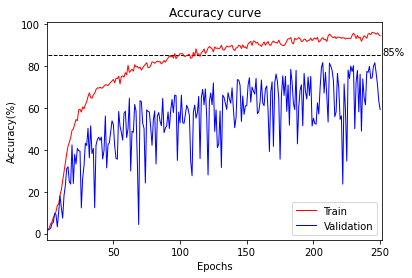

In [30]:
epoch = []
train_acc = []
val_acc = []
train_loss = []
val_loss = []

with open('./results/epoch_curve_plotting_data.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines, None)
    for row in lines:
        epoch.append(int(row[0]))
        train_acc.append(float(row[1])*100)
        train_loss.append(float(row[2]))
        val_acc.append(float(row[3])*100)
        val_loss.append(float(row[4]))

# plt accuracy curve
plt.figure()

plt.plot([1, 250.5], [85, 85], color='black', linestyle='dashed', lw=1)
plt.gca().text(252, 85, '85%', color='black')

plt.plot(epoch, train_acc, color = 'red', linewidth = '1', label = 'Train')
plt.plot(epoch, val_acc, color = 'blue', linewidth = '1', label = 'Validation')

plt.xlim(0.5, 251.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.title('Accuracy curve')
plt.legend(loc='lower right')

plt.savefig('./plots/acc_comparison(task2)_4.png')
plt.show()

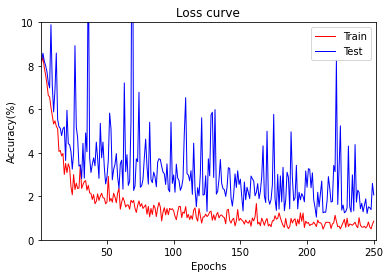

In [31]:
# plt loss curve
plt.figure()

plt.plot(epoch, train_loss, color = 'red', linewidth = '1', label = 'Train')
plt.plot(epoch, val_loss, color = 'blue', linewidth = '1', label = 'Test')

plt.xlim(0.5, 251.5)
plt.ylim(0, 10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.title('Loss curve')
plt.legend(loc='upper right')

plt.savefig('./plots/loss_comparison(task2)_4.png')
plt.show()

Task 3

In [7]:
class Task3Dataset(Dataset):
    def __init__(self, data, root, return_filename=False):
        self.data = [sample for sample in data if sample[0].startswith("task3")]
        self.return_filename = return_filename
        self.root = root
        
        self.transform = transforms.Compose([
            #transforms.Resize(96),
            #transforms.RandomRotation(degrees=20),
            transforms.ToTensor()
        ])
    
    def __getitem__(self, index):
        filename, label = self.data[index]
        img = cv2.imread("{}/{}".format(self.root, filename))
        img = cv2.resize(img, (96, 96))
        img = cv2.medianBlur(img, 5)
        img = np.mean(img, axis=2)
        img = Image.fromarray(img)
        img = self.transform(img)
        
        label_list = [[alphabets2index[digit]] for digit in label]
        label_list = np.array(label_list)
        #print(label_list)
        
        length = [len(label_list)]
        
        #label_list = [length] + label_list
        label_list = np.append([length], label_list, axis=0)
        
        if self.return_filename:
            return torch.FloatTensor((img - 128) / 128), filename
        else:
            return torch.FloatTensor((img - 128) / 128), label_list

    def __len__(self):
        return len(self.data)

In [8]:
train_data = []
val_data = []

with open('{}/annotations.csv'.format(TRAIN_PATH), newline='') as csvfile:
    for row in csv.reader(csvfile, delimiter=','):
        if random.random() < 0.8:
            train_data.append(row)
        else:
            val_data.append(row)

train_ds = Task3Dataset(train_data, root=TRAIN_PATH)
train_dl = DataLoader(train_ds, batch_size=32, num_workers=0, drop_last=True, shuffle=True)

val_ds = Task3Dataset(val_data, root=TRAIN_PATH)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0, drop_last=False, shuffle=False)

In [9]:
class ResNet18_t3(nn.Module):
    def __init__(self):
        super(ResNet18_t3, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64, None),
            BasicBlock(64, 64, None)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, (2, 2)),
            BasicBlock(128, 128, None)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, (2, 2)),
            BasicBlock(256, 256, None)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, (2, 2)),
            BasicBlock(512, 512, None)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.digitlength = nn.Linear(512, 1)
        self.digit1 = nn.Linear(512, len(alphabets))
        self.digit2 = nn.Linear(512, len(alphabets))
        self.digit3 = nn.Linear(512, len(alphabets))
        self.digit4 = nn.Linear(512, len(alphabets))

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        yl = self.digitlength(out.reshape(out.shape[0], -1))
        y1 = self.digit1(out.reshape(out.shape[0], -1))
        y2 = self.digit2(out.reshape(out.shape[0], -1))
        y3 = self.digit3(out.reshape(out.shape[0], -1))
        y4 = self.digit4(out.reshape(out.shape[0], -1))
        return [yl, y1, y2, y3, y4]

In [10]:
model = ResNet18_t3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04, weight_decay=5e-03)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
epoch = 200

cpt_dir = './model_weights/'
os.makedirs(cpt_dir, exist_ok=True)
phase_dir = './results/'
os.makedirs(phase_dir, exist_ok=True)

In [11]:
summary(model, input_size=(1, 96, 96), batch_size = 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 48, 48]           3,136
       BatchNorm2d-2           [32, 64, 48, 48]             128
              ReLU-3           [32, 64, 48, 48]               0
         MaxPool2d-4           [32, 64, 24, 24]               0
            Conv2d-5           [32, 64, 24, 24]          36,864
       BatchNorm2d-6           [32, 64, 24, 24]             128
              ReLU-7           [32, 64, 24, 24]               0
            Conv2d-8           [32, 64, 24, 24]          36,864
       BatchNorm2d-9           [32, 64, 24, 24]             128
             ReLU-10           [32, 64, 24, 24]               0
       BasicBlock-11           [32, 64, 24, 24]               0
           Conv2d-12           [32, 64, 24, 24]          36,864
      BatchNorm2d-13           [32, 64, 24, 24]             128
             ReLU-14           [32, 64,

In [12]:
# Write the labels of the csv for plotting
headerList = ['Epoch', 'Training accuracy', 'Training loss', 'Validation acurracy', 'Validation loss']

with open('./results/epoch_curve_plotting_data.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerow(headerList)

In [13]:
epoch_pbar = tqdm(range(1, epoch+1))

for epoch in epoch_pbar:
    
    # save epoch
    epoch_plotting_data = []
    epoch_plotting_data.append(epoch)
    
    print("Epoch [{}]".format(epoch))
    
    sample_count = 0
    correct_count = 0
    model.train()
    batch_pbar = tqdm(train_dl)
    for batch_idx, (image, label) in enumerate(batch_pbar):
        image = image.to(device)
        label = label.to(device=device, dtype=torch.float64)
        
        lenths = label[:, 0]
        bin4 = []
        bin2 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 2):
                bin2.append(idx)
            elif (lenth == 4):
                bin4.append(idx)
        
        # optimizer.zero_grad()
        outputs = model(image)
                
        if bin4:
            idxs = torch.tensor(bin4, dtype=torch.int64)
            Y = label[idxs].to(device)
            lossl = loss_fn(outputs[0][idxs], Y[:, 0])
            loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
            loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
            loss3 = loss_fn(outputs[3][idxs], torch.tensor(Y[:, 3].squeeze(1), dtype=torch.int64))
            loss4 = loss_fn(outputs[4][idxs], torch.tensor(Y[:, 4].squeeze(1), dtype=torch.int64))
            lossd2 = lossl + loss1 + loss2 + loss3 + loss4
            
            lossd2.backward()
            optimizer.step()
        
            pred1 = torch.argmax(outputs[1][idxs], dim=1)
            pred2 = torch.argmax(outputs[2][idxs], dim=1)
            pred3 = torch.argmax(outputs[3][idxs], dim=1)
            pred4 = torch.argmax(outputs[4][idxs], dim=1)
            
            sample_count += len(image)
            
            for i in range(idx+1):
                if (pred1[i] == torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
                if (pred2[i] == torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
                if (pred3[i] == torch.tensor(Y[:, 3].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
                if (pred4[i] == torch.tensor(Y[:, 4].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
    
    scheduler.step()
    epoch_plotting_data.append(correct_count/sample_count)
    epoch_plotting_data.append(lossd2.item())
        
    sample_count = 0
    correct_count = 0
    model.eval()
    batch_pbar = tqdm(val_dl)
    for batch_idx, (image, label) in enumerate(batch_pbar):
        image = image.to(device)
        label = label.to(device=device, dtype=torch.float64)
        
        lenths = label[:, 0]
        bin4 = []
        bin2 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 2):
                bin2.append(idx)
            elif (lenth == 4):
                bin4.append(idx)
                
        outputs = model(image)
                
        if bin4:
            idxs = torch.tensor(bin4, dtype=torch.int64)
            Y = label[idxs].to(device)
            lossl = loss_fn(outputs[0][idxs], Y[:, 0])
            loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
            loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
            loss3 = loss_fn(outputs[3][idxs], torch.tensor(Y[:, 3].squeeze(1), dtype=torch.int64))
            loss4 = loss_fn(outputs[4][idxs], torch.tensor(Y[:, 4].squeeze(1), dtype=torch.int64))
            lossd2 = lossl + loss1 + loss2 + loss3 + loss4
        
            pred1 = torch.argmax(outputs[1][idxs], dim=1)
            pred2 = torch.argmax(outputs[2][idxs], dim=1)
            pred3 = torch.argmax(outputs[3][idxs], dim=1)
            pred4 = torch.argmax(outputs[4][idxs], dim=1)
            
            sample_count += len(image)
            
            for i in range(idx+1):
                if (pred1[i] == torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
                if (pred2[i] == torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
                if (pred3[i] == torch.tensor(Y[:, 3].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
                if (pred4[i] == torch.tensor(Y[:, 4].squeeze(1), dtype=torch.int64)[i]):
                    correct_count += 0.25
    
    epoch_plotting_data.append(correct_count/sample_count)
    epoch_plotting_data.append(lossd2.item())
    
    with open('./results/epoch_curve_plotting_data.csv', 'a+', newline ='') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerow(epoch_plotting_data)
    
    torch.save(model.state_dict(), os.path.join(cpt_dir, 'epoch{}.pt'.format(epoch)))
        
    print("accuracy (validation):", correct_count / sample_count)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch [1]



  0%|                                                                                           | 0/99 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_39688\125865288.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_39688\125865288.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_39688\125865288.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.15it/s]

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_39688\125865288.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss1 = loss_fn(outputs[1][idxs], torch.tensor(Y[:, 1].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_39688\125865288.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss2 = loss_fn(outputs[2][idxs], torch.tensor(Y[:, 2].squeeze(1), dtype=torch.int64))
C:\Users\user\AppData\Local\Temp\ipykernel_39688\125865288

  0%|▍                                                                                 | 1/200 [00:16<53:10, 16.03s/it]

accuracy (validation): 0.03372524752475248
Epoch [2]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.77it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  7.06it/s]

  1%|▊                                                                                 | 2/200 [00:32<52:54, 16.03s/it]

accuracy (validation): 0.06775990099009901
Epoch [3]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.84it/s]

  2%|█▏                                                                                | 3/200 [00:47<51:01, 15.54s/it]

accuracy (validation): 0.07797029702970297
Epoch [4]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.44it/s]

  2%|█▋                                                                                | 4/200 [01:02<50:26, 15.44s/it]

accuracy (validation): 0.09158415841584158
Epoch [5]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.50it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.68it/s]

  2%|██                                                                                | 5/200 [01:17<49:31, 15.24s/it]

accuracy (validation): 0.09962871287128713
Epoch [6]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.54it/s]

  3%|██▍                                                                               | 6/200 [01:32<49:08, 15.20s/it]

accuracy (validation): 0.11478960396039604
Epoch [7]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.65it/s]

  4%|██▊                                                                               | 7/200 [01:47<48:37, 15.12s/it]

accuracy (validation): 0.1296410891089109
Epoch [8]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.44it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.45it/s]

  4%|███▎                                                                              | 8/200 [02:02<48:30, 15.16s/it]

accuracy (validation): 0.14108910891089108
Epoch [9]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.17it/s]

  4%|███▋                                                                              | 9/200 [02:18<49:00, 15.40s/it]

accuracy (validation): 0.14511138613861385
Epoch [10]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.63it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.86it/s]

  5%|████                                                                             | 10/200 [02:34<49:45, 15.72s/it]

accuracy (validation): 0.15655940594059406
Epoch [11]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.37it/s]

  6%|████▍                                                                            | 11/200 [02:50<49:19, 15.66s/it]

accuracy (validation): 0.1661509900990099
Epoch [12]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.59it/s]

  6%|████▊                                                                            | 12/200 [03:05<48:36, 15.51s/it]

accuracy (validation): 0.1806930693069307
Epoch [13]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.15it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.20it/s]

  6%|█████▎                                                                           | 13/200 [03:21<48:36, 15.60s/it]

accuracy (validation): 0.20327970297029702
Epoch [14]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:05,  6.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.26it/s]

  7%|█████▋                                                                           | 14/200 [03:37<48:26, 15.63s/it]

accuracy (validation): 0.2042079207920792
Epoch [15]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.43it/s]

  8%|██████                                                                           | 15/200 [03:52<48:04, 15.59s/it]

accuracy (validation): 0.20544554455445543
Epoch [16]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.38it/s]

  8%|██████▍                                                                          | 16/200 [04:07<47:38, 15.54s/it]

accuracy (validation): 0.2119430693069307
Epoch [17]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.84it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.50it/s]

  8%|██████▉                                                                          | 17/200 [04:23<47:08, 15.46s/it]

accuracy (validation): 0.22431930693069307
Epoch [18]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.55it/s]

  9%|███████▎                                                                         | 18/200 [04:38<46:41, 15.39s/it]

accuracy (validation): 0.24597772277227722
Epoch [19]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.46it/s]

 10%|███████▋                                                                         | 19/200 [04:53<46:21, 15.36s/it]

accuracy (validation): 0.2537128712871287
Epoch [20]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.60it/s]

 10%|████████                                                                         | 20/200 [05:08<45:44, 15.25s/it]

accuracy (validation): 0.26392326732673266
Epoch [21]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.62it/s]

 10%|████████▌                                                                        | 21/200 [05:23<45:17, 15.18s/it]

accuracy (validation): 0.26794554455445546
Epoch [22]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.54it/s]

 11%|████████▉                                                                        | 22/200 [05:38<45:00, 15.17s/it]

accuracy (validation): 0.28898514851485146
Epoch [23]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.51it/s]

 12%|█████████▎                                                                       | 23/200 [05:54<44:47, 15.19s/it]

accuracy (validation): 0.29207920792079206
Epoch [24]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.56it/s]

 12%|█████████▋                                                                       | 24/200 [06:09<44:27, 15.16s/it]

accuracy (validation): 0.28867574257425743
Epoch [25]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.71it/s]

 12%|██████████▏                                                                      | 25/200 [06:24<43:53, 15.05s/it]

accuracy (validation): 0.3032178217821782
Epoch [26]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.56it/s]

 13%|██████████▌                                                                      | 26/200 [06:39<43:39, 15.06s/it]

accuracy (validation): 0.30507425742574257
Epoch [27]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.48it/s]

 14%|██████████▉                                                                      | 27/200 [06:54<43:39, 15.14s/it]

accuracy (validation): 0.3146658415841584
Epoch [28]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.28it/s]

 14%|███████████▎                                                                     | 28/200 [07:10<43:54, 15.32s/it]

accuracy (validation): 0.3193069306930693
Epoch [29]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.30it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.31it/s]

 14%|███████████▋                                                                     | 29/200 [07:25<43:51, 15.39s/it]

accuracy (validation): 0.328279702970297
Epoch [30]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.16it/s]

 15%|████████████▏                                                                    | 30/200 [07:41<44:01, 15.54s/it]

accuracy (validation): 0.33879950495049505
Epoch [31]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.49it/s]

 16%|████████████▌                                                                    | 31/200 [07:56<43:33, 15.46s/it]

accuracy (validation): 0.33601485148514854
Epoch [32]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.22it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  7.06it/s]

 16%|████████████▉                                                                    | 32/200 [08:13<43:51, 15.67s/it]

accuracy (validation): 0.3502475247524752
Epoch [33]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.16it/s]

 16%|█████████████▎                                                                   | 33/200 [08:28<43:47, 15.74s/it]

accuracy (validation): 0.3530321782178218
Epoch [34]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.49it/s]

 17%|█████████████▊                                                                   | 34/200 [08:44<43:09, 15.60s/it]

accuracy (validation): 0.3558168316831683
Epoch [35]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.50it/s]

 18%|██████████████▏                                                                  | 35/200 [08:59<42:39, 15.51s/it]

accuracy (validation): 0.3681930693069307
Epoch [36]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.54it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.35it/s]

 18%|██████████████▌                                                                  | 36/200 [09:15<42:26, 15.52s/it]

accuracy (validation): 0.38242574257425743
Epoch [37]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.33it/s]

 18%|██████████████▉                                                                  | 37/200 [09:30<42:12, 15.54s/it]

accuracy (validation): 0.3849009900990099
Epoch [38]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.65it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.42it/s]

 19%|███████████████▍                                                                 | 38/200 [09:46<42:05, 15.59s/it]

accuracy (validation): 0.3870668316831683
Epoch [39]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  7.00it/s]

 20%|███████████████▊                                                                 | 39/200 [10:02<42:22, 15.79s/it]

accuracy (validation): 0.3941831683168317
Epoch [40]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.14it/s]

 20%|████████████████▏                                                                | 40/200 [10:18<42:12, 15.83s/it]

accuracy (validation): 0.3994430693069307
Epoch [41]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.43it/s]

 20%|████████████████▌                                                                | 41/200 [10:33<41:37, 15.71s/it]

accuracy (validation): 0.40191831683168316
Epoch [42]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.44it/s]

 21%|█████████████████                                                                | 42/200 [10:49<41:04, 15.60s/it]

accuracy (validation): 0.40717821782178215
Epoch [43]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.42it/s]

 22%|█████████████████▍                                                               | 43/200 [11:04<40:37, 15.53s/it]

accuracy (validation): 0.4121287128712871
Epoch [44]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.87it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.44it/s]

 22%|█████████████████▊                                                               | 44/200 [11:20<40:13, 15.47s/it]

accuracy (validation): 0.41367574257425743
Epoch [45]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.84it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.48it/s]

 22%|██████████████████▏                                                              | 45/200 [11:35<39:51, 15.43s/it]

accuracy (validation): 0.4146039603960396
Epoch [46]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.55it/s]

 23%|██████████████████▋                                                              | 46/200 [11:50<39:23, 15.35s/it]

accuracy (validation): 0.4146039603960396
Epoch [47]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.45it/s]

 24%|███████████████████                                                              | 47/200 [12:05<39:07, 15.34s/it]

accuracy (validation): 0.41336633663366334
Epoch [48]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.38it/s]

 24%|███████████████████▍                                                             | 48/200 [12:21<39:01, 15.40s/it]

accuracy (validation): 0.4251237623762376
Epoch [49]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.12it/s]

 24%|███████████████████▊                                                             | 49/200 [12:37<39:14, 15.59s/it]

accuracy (validation): 0.4238861386138614
Epoch [50]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.43it/s]

 25%|████████████████████▎                                                            | 50/200 [12:52<38:53, 15.56s/it]

accuracy (validation): 0.42574257425742573
Epoch [51]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.53it/s]

 26%|████████████████████▋                                                            | 51/200 [13:08<38:19, 15.43s/it]

accuracy (validation): 0.42883663366336633
Epoch [52]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.50it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.59it/s]

 26%|█████████████████████                                                            | 52/200 [13:23<37:51, 15.35s/it]

accuracy (validation): 0.4313118811881188
Epoch [53]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.73it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.33it/s]

 26%|█████████████████████▍                                                           | 53/200 [13:38<37:46, 15.42s/it]

accuracy (validation): 0.43038366336633666
Epoch [54]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.41it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.56it/s]

 27%|█████████████████████▊                                                           | 54/200 [13:53<37:23, 15.36s/it]

accuracy (validation): 0.4375
Epoch [55]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.16it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.31it/s]

 28%|██████████████████████▎                                                          | 55/200 [14:09<37:18, 15.43s/it]

accuracy (validation): 0.43657178217821785
Epoch [56]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.50it/s]

 28%|██████████████████████▋                                                          | 56/200 [14:24<36:56, 15.39s/it]

accuracy (validation): 0.44090346534653463
Epoch [57]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.27it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.13it/s]

 28%|███████████████████████                                                          | 57/200 [14:40<37:02, 15.54s/it]

accuracy (validation): 0.4443069306930693
Epoch [58]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.81it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.44it/s]

 29%|███████████████████████▍                                                         | 58/200 [14:56<36:37, 15.47s/it]

accuracy (validation): 0.4458539603960396
Epoch [59]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.41it/s]

 30%|███████████████████████▉                                                         | 59/200 [15:11<36:20, 15.47s/it]

accuracy (validation): 0.4467821782178218
Epoch [60]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.30it/s]

 30%|████████████████████████▎                                                        | 60/200 [15:27<36:23, 15.59s/it]

accuracy (validation): 0.4520420792079208
Epoch [61]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.73it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.44it/s]

 30%|████████████████████████▋                                                        | 61/200 [15:42<35:57, 15.52s/it]

accuracy (validation): 0.45482673267326734
Epoch [62]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.08it/s]

 31%|█████████████████████████                                                        | 62/200 [15:59<36:37, 15.93s/it]

accuracy (validation): 0.4535891089108911
Epoch [63]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:06,  5.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.61it/s]

 32%|█████████████████████████▌                                                       | 63/200 [16:16<37:05, 16.25s/it]

accuracy (validation): 0.45823019801980197
Epoch [64]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:06,  5.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.96it/s]

 32%|█████████████████████████▉                                                       | 64/200 [16:33<36:54, 16.28s/it]

accuracy (validation): 0.4591584158415842
Epoch [65]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  7.04it/s]

 32%|██████████████████████████▎                                                      | 65/200 [16:49<36:42, 16.31s/it]

accuracy (validation): 0.4573019801980198
Epoch [66]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  5.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.48it/s]

 33%|██████████████████████████▋                                                      | 66/200 [17:07<37:26, 16.77s/it]

accuracy (validation): 0.4625618811881188
Epoch [67]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:11<00:06,  5.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.07it/s]

 34%|███████████████████████████▏                                                     | 67/200 [17:25<38:26, 17.34s/it]

accuracy (validation): 0.45823019801980197
Epoch [68]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.25it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.67it/s]

 34%|███████████████████████████▌                                                     | 68/200 [17:43<38:00, 17.28s/it]

accuracy (validation): 0.4622524752475248
Epoch [69]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.50it/s]

 34%|███████████████████████████▉                                                     | 69/200 [18:00<38:05, 17.45s/it]

accuracy (validation): 0.4659653465346535
Epoch [70]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.05it/s]

 35%|████████████████████████████▎                                                    | 70/200 [18:19<38:37, 17.83s/it]

accuracy (validation): 0.4709158415841584
Epoch [71]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:04,  6.87it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.32it/s]

 36%|████████████████████████████▊                                                    | 71/200 [18:37<38:38, 17.98s/it]

accuracy (validation): 0.4724628712871287
Epoch [72]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:06,  5.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.41it/s]

 36%|█████████████████████████████▏                                                   | 72/200 [18:55<38:14, 17.93s/it]

accuracy (validation): 0.47060643564356436
Epoch [73]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.37it/s]

 36%|█████████████████████████████▌                                                   | 73/200 [19:13<37:57, 17.94s/it]

accuracy (validation): 0.4709158415841584
Epoch [74]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.66it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.42it/s]

 37%|█████████████████████████████▉                                                   | 74/200 [19:31<37:33, 17.88s/it]

accuracy (validation): 0.46875
Epoch [75]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  6.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.55it/s]

 38%|██████████████████████████████▍                                                  | 75/200 [19:48<36:58, 17.74s/it]

accuracy (validation): 0.4715346534653465
Epoch [76]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.60it/s]

 38%|██████████████████████████████▊                                                  | 76/200 [20:06<36:24, 17.61s/it]

accuracy (validation): 0.47277227722772275
Epoch [77]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.48it/s]

 38%|███████████████████████████████▏                                                 | 77/200 [20:23<36:06, 17.62s/it]

accuracy (validation): 0.4718440594059406
Epoch [78]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.45it/s]

 39%|███████████████████████████████▌                                                 | 78/200 [20:41<35:52, 17.64s/it]

accuracy (validation): 0.47308168316831684
Epoch [79]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.45it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.41it/s]

 40%|███████████████████████████████▉                                                 | 79/200 [20:59<35:40, 17.69s/it]

accuracy (validation): 0.4752475247524752
Epoch [80]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  6.92it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.50it/s]

 40%|████████████████████████████████▍                                                | 80/200 [21:17<35:24, 17.70s/it]

accuracy (validation): 0.47741336633663367
Epoch [81]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.07it/s]

 40%|████████████████████████████████▊                                                | 81/200 [21:36<35:53, 18.09s/it]

accuracy (validation): 0.4811262376237624
Epoch [82]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:12<00:05,  6.32it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:18<00:00,  5.47it/s]

 41%|█████████████████████████████████▏                                               | 82/200 [21:56<37:01, 18.83s/it]

accuracy (validation): 0.4783415841584158
Epoch [83]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.73it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.53it/s]

 42%|█████████████████████████████████▌                                               | 83/200 [22:14<35:58, 18.44s/it]

accuracy (validation): 0.4755569306930693
Epoch [84]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:11<00:06,  5.03it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  5.93it/s]

 42%|██████████████████████████████████                                               | 84/200 [22:33<36:04, 18.66s/it]

accuracy (validation): 0.4814356435643564
Epoch [85]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.49it/s]

 42%|██████████████████████████████████▍                                              | 85/200 [22:51<35:14, 18.39s/it]

accuracy (validation): 0.484529702970297
Epoch [86]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.31it/s]

 43%|██████████████████████████████████▊                                              | 86/200 [23:09<34:43, 18.28s/it]

accuracy (validation): 0.48050742574257427
Epoch [87]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.49it/s]

 44%|███████████████████████████████████▏                                             | 87/200 [23:26<33:59, 18.05s/it]

accuracy (validation): 0.48514851485148514
Epoch [88]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  5.91it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.15it/s]

 44%|███████████████████████████████████▋                                             | 88/200 [23:45<33:58, 18.20s/it]

accuracy (validation): 0.4817450495049505
Epoch [89]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:04,  6.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.34it/s]

 44%|████████████████████████████████████                                             | 89/200 [24:03<33:34, 18.15s/it]

accuracy (validation): 0.48514851485148514
Epoch [90]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.38it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.49it/s]

 45%|████████████████████████████████████▍                                            | 90/200 [24:20<33:01, 18.01s/it]

accuracy (validation): 0.4879331683168317
Epoch [91]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.31it/s]

 46%|████████████████████████████████████▊                                            | 91/200 [24:39<32:48, 18.06s/it]

accuracy (validation): 0.4876237623762376
Epoch [92]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.26it/s]

 46%|█████████████████████████████████████▎                                           | 92/200 [24:57<32:35, 18.11s/it]

accuracy (validation): 0.48514851485148514
Epoch [93]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:11<00:05,  5.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:17<00:00,  5.79it/s]

 46%|█████████████████████████████████████▋                                           | 93/200 [25:16<33:02, 18.53s/it]

accuracy (validation): 0.49133663366336633
Epoch [94]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.53it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.55it/s]

 47%|██████████████████████████████████████                                           | 94/200 [25:34<32:17, 18.28s/it]

accuracy (validation): 0.4870049504950495
Epoch [95]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  5.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.14it/s]

 48%|██████████████████████████████████████▍                                          | 95/200 [25:53<32:07, 18.36s/it]

accuracy (validation): 0.4876237623762376
Epoch [96]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.32it/s]

 48%|██████████████████████████████████████▉                                          | 96/200 [26:11<31:48, 18.35s/it]

accuracy (validation): 0.4916460396039604
Epoch [97]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  5.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  5.97it/s]

 48%|███████████████████████████████████████▎                                         | 97/200 [26:30<31:46, 18.51s/it]

accuracy (validation): 0.48978960396039606
Epoch [98]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.20it/s]

 49%|███████████████████████████████████████▋                                         | 98/200 [26:49<31:43, 18.66s/it]

accuracy (validation): 0.49195544554455445
Epoch [99]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:11<00:05,  6.27it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  5.98it/s]

 50%|████████████████████████████████████████                                         | 99/200 [27:07<31:27, 18.69s/it]

accuracy (validation): 0.4938118811881188
Epoch [100]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.25it/s]

 50%|████████████████████████████████████████                                        | 100/200 [27:23<29:44, 17.85s/it]

accuracy (validation): 0.4916460396039604
Epoch [101]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.93it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.25it/s]

 50%|████████████████████████████████████████▍                                       | 101/200 [27:39<28:25, 17.23s/it]

accuracy (validation): 0.4910272277227723
Epoch [102]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.27it/s]

 51%|████████████████████████████████████████▊                                       | 102/200 [27:55<27:23, 16.77s/it]

accuracy (validation): 0.4944306930693069
Epoch [103]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.08it/s]

 52%|█████████████████████████████████████████▏                                      | 103/200 [28:11<26:46, 16.56s/it]

accuracy (validation): 0.49288366336633666
Epoch [104]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.34it/s]

 52%|█████████████████████████████████████████▌                                      | 104/200 [28:27<26:05, 16.30s/it]

accuracy (validation): 0.494740099009901
Epoch [105]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.25it/s]

 52%|██████████████████████████████████████████                                      | 105/200 [28:42<25:34, 16.15s/it]

accuracy (validation): 0.4904084158415842
Epoch [106]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  6.91it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.20it/s]

 53%|██████████████████████████████████████████▍                                     | 106/200 [28:58<25:09, 16.06s/it]

accuracy (validation): 0.4854579207920792
Epoch [107]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.11it/s]

 54%|██████████████████████████████████████████▊                                     | 107/200 [29:14<24:52, 16.04s/it]

accuracy (validation): 0.4870049504950495
Epoch [108]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.37it/s]

 54%|███████████████████████████████████████████▏                                    | 108/200 [29:30<24:25, 15.93s/it]

accuracy (validation): 0.4907178217821782
Epoch [109]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.95it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.37it/s]

 55%|███████████████████████████████████████████▌                                    | 109/200 [29:46<23:59, 15.82s/it]

accuracy (validation): 0.4907178217821782
Epoch [110]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.44it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.80it/s]

 55%|████████████████████████████████████████████                                    | 110/200 [30:02<24:13, 16.15s/it]

accuracy (validation): 0.49288366336633666
Epoch [111]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.60it/s]

 56%|████████████████████████████████████████████▍                                   | 111/200 [30:20<24:26, 16.47s/it]

accuracy (validation): 0.4916460396039604
Epoch [112]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  6.81it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.70it/s]

 56%|████████████████████████████████████████████▊                                   | 112/200 [30:37<24:23, 16.63s/it]

accuracy (validation): 0.4938118811881188
Epoch [113]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.15it/s]

 56%|█████████████████████████████████████████████▏                                  | 113/200 [30:53<23:53, 16.47s/it]

accuracy (validation): 0.48948019801980197
Epoch [114]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  7.03it/s]

 57%|█████████████████████████████████████████████▌                                  | 114/200 [31:09<23:37, 16.48s/it]

accuracy (validation): 0.494740099009901
Epoch [115]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.98it/s]

 57%|██████████████████████████████████████████████                                  | 115/200 [31:26<23:20, 16.48s/it]

accuracy (validation): 0.4907178217821782
Epoch [116]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:17<00:00,  5.80it/s]

 58%|██████████████████████████████████████████████▍                                 | 116/200 [31:45<24:12, 17.29s/it]

accuracy (validation): 0.49504950495049505
Epoch [117]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  6.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.18it/s]

 58%|██████████████████████████████████████████████▊                                 | 117/200 [32:04<24:28, 17.69s/it]

accuracy (validation): 0.49226485148514854
Epoch [118]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.68it/s]

 59%|███████████████████████████████████████████████▏                                | 118/200 [32:21<23:59, 17.55s/it]

accuracy (validation): 0.4969059405940594
Epoch [119]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:04,  7.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.42it/s]

 60%|███████████████████████████████████████████████▌                                | 119/200 [32:38<23:42, 17.57s/it]

accuracy (validation): 0.4993811881188119
Epoch [120]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:05,  5.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:16<00:00,  6.18it/s]

 60%|████████████████████████████████████████████████                                | 120/200 [32:57<23:52, 17.90s/it]

accuracy (validation): 0.49969059405940597
Epoch [121]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:10<00:04,  7.05it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:15<00:00,  6.47it/s]

 60%|████████████████████████████████████████████████▍                               | 121/200 [33:15<23:26, 17.81s/it]

accuracy (validation): 0.4935024752475248
Epoch [122]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:05,  6.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.64it/s]

 61%|████████████████████████████████████████████████▊                               | 122/200 [33:32<23:00, 17.70s/it]

accuracy (validation): 0.4975247524752475
Epoch [123]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  6.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.85it/s]

 62%|█████████████████████████████████████████████████▏                              | 123/200 [33:49<22:17, 17.37s/it]

accuracy (validation): 0.4910272277227723
Epoch [124]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.45it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.47it/s]

 62%|█████████████████████████████████████████████████▌                              | 124/200 [34:04<21:12, 16.74s/it]

accuracy (validation): 0.49597772277227725
Epoch [125]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.55it/s]

 62%|██████████████████████████████████████████████████                              | 125/200 [34:19<20:21, 16.28s/it]

accuracy (validation): 0.5012376237623762
Epoch [126]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.39it/s]

 63%|██████████████████████████████████████████████████▍                             | 126/200 [34:35<19:49, 16.07s/it]

accuracy (validation): 0.5
Epoch [127]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.43it/s]

 64%|██████████████████████████████████████████████████▊                             | 127/200 [34:50<19:17, 15.86s/it]

accuracy (validation): 0.5030940594059405
Epoch [128]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.61it/s]

 64%|███████████████████████████████████████████████████▏                            | 128/200 [35:05<18:43, 15.60s/it]

accuracy (validation): 0.5
Epoch [129]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.61it/s]

 64%|███████████████████████████████████████████████████▌                            | 129/200 [35:20<18:15, 15.43s/it]

accuracy (validation): 0.5018564356435643
Epoch [130]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.45it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.50it/s]

 65%|████████████████████████████████████████████████████                            | 130/200 [35:35<17:55, 15.37s/it]

accuracy (validation): 0.49876237623762376
Epoch [131]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.35it/s]

 66%|████████████████████████████████████████████████████▍                           | 131/200 [35:51<17:43, 15.42s/it]

accuracy (validation): 0.49907178217821785
Epoch [132]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.49it/s]

 66%|████████████████████████████████████████████████████▊                           | 132/200 [36:06<17:25, 15.37s/it]

accuracy (validation): 0.4972153465346535
Epoch [133]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.50it/s]

 66%|█████████████████████████████████████████████████████▏                          | 133/200 [36:21<17:06, 15.32s/it]

accuracy (validation): 0.49659653465346537
Epoch [134]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:20<00:00,  4.85it/s]

 67%|█████████████████████████████████████████████████████▌                          | 134/200 [36:46<19:56, 18.14s/it]

accuracy (validation): 0.49845297029702973
Epoch [135]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:14,  2.35it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.57it/s]

 68%|██████████████████████████████████████████████████████                          | 135/200 [37:30<27:59, 25.83s/it]

accuracy (validation): 0.49969059405940597
Epoch [136]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.56it/s]

 68%|██████████████████████████████████████████████████████▍                         | 136/200 [38:14<33:26, 31.35s/it]

accuracy (validation): 0.4972153465346535
Epoch [137]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.58it/s]

 68%|██████████████████████████████████████████████████████▊                         | 137/200 [38:58<36:45, 35.01s/it]

accuracy (validation): 0.4907178217821782
Epoch [138]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:11,  3.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.73it/s]

 69%|███████████████████████████████████████████████████████▏                        | 138/200 [39:39<38:13, 36.99s/it]

accuracy (validation): 0.4978341584158416
Epoch [139]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.58it/s]

 70%|███████████████████████████████████████████████████████▌                        | 139/200 [40:23<39:32, 38.89s/it]

accuracy (validation): 0.5012376237623762
Epoch [140]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.75it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.62it/s]

 70%|████████████████████████████████████████████████████████                        | 140/200 [41:06<40:11, 40.20s/it]

accuracy (validation): 0.49597772277227725
Epoch [141]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:13,  2.44it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.56it/s]

 70%|████████████████████████████████████████████████████████▍                       | 141/200 [41:51<40:51, 41.55s/it]

accuracy (validation): 0.49907178217821785
Epoch [142]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:11,  2.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.66it/s]

 71%|████████████████████████████████████████████████████████▊                       | 142/200 [42:33<40:24, 41.80s/it]

accuracy (validation): 0.4972153465346535
Epoch [143]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:13,  2.55it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.56it/s]

 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [43:17<40:25, 42.55s/it]

accuracy (validation): 0.4972153465346535
Epoch [144]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:12,  2.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.75it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [43:58<39:08, 41.94s/it]

accuracy (validation): 0.49535891089108913
Epoch [145]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:22<00:11,  2.85it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:33<00:00,  2.93it/s]

 72%|██████████████████████████████████████████████████████████                      | 145/200 [44:36<37:28, 40.88s/it]

accuracy (validation): 0.5027846534653465
Epoch [146]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:13,  2.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.80it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [45:17<36:50, 40.94s/it]

accuracy (validation): 0.4978341584158416
Epoch [147]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.63it/s]

 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [46:01<36:53, 41.76s/it]

accuracy (validation): 0.5018564356435643
Epoch [148]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:12,  2.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.75it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [46:42<35:55, 41.46s/it]

accuracy (validation): 0.49845297029702973
Epoch [149]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:11,  2.91it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.78it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [47:22<35:03, 41.25s/it]

accuracy (validation): 0.500309405940594
Epoch [150]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.63it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.61it/s]

 75%|████████████████████████████████████████████████████████████                    | 150/200 [48:05<34:46, 41.73s/it]

accuracy (validation): 0.49814356435643564
Epoch [151]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:26<00:15,  2.22it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:40<00:00,  2.43it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [48:51<35:07, 43.01s/it]

accuracy (validation): 0.49907178217821785
Epoch [152]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:13,  2.54it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.53it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [49:36<34:45, 43.46s/it]

accuracy (validation): 0.5018564356435643
Epoch [153]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.51it/s]

 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [50:21<34:28, 44.01s/it]

accuracy (validation): 0.49876237623762376
Epoch [154]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:26<00:13,  2.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:40<00:00,  2.42it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [51:07<34:12, 44.62s/it]

accuracy (validation): 0.4972153465346535
Epoch [155]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:14,  2.41it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.68it/s]

 78%|██████████████████████████████████████████████████████████████                  | 155/200 [51:49<32:51, 43.82s/it]

accuracy (validation): 0.5
Epoch [156]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.73it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.63it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [52:32<31:55, 43.54s/it]

accuracy (validation): 0.49597772277227725
Epoch [157]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:14,  2.41it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.53it/s]

 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [53:17<31:33, 44.03s/it]

accuracy (validation): 0.4962871287128713
Epoch [158]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:15,  2.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.58it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [54:01<30:52, 44.11s/it]

accuracy (validation): 0.5006188118811881
Epoch [159]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.63it/s]

 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [54:44<29:53, 43.73s/it]

accuracy (validation): 0.5021658415841584
Epoch [160]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:13,  2.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.54it/s]

 80%|████████████████████████████████████████████████████████████████                | 160/200 [55:28<29:12, 43.82s/it]

accuracy (validation): 0.4944306930693069
Epoch [161]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:13,  2.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.52it/s]

 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [56:12<28:31, 43.88s/it]

accuracy (validation): 0.49288366336633666
Epoch [162]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.53it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [56:57<27:56, 44.12s/it]

accuracy (validation): 0.4941212871287129
Epoch [163]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:11,  2.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.59it/s]

 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [57:40<27:02, 43.84s/it]

accuracy (validation): 0.4969059405940594
Epoch [164]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:11,  2.92it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.72it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [58:21<25:43, 42.89s/it]

accuracy (validation): 0.500309405940594
Epoch [165]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:21<00:11,  2.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.83it/s]

 82%|██████████████████████████████████████████████████████████████████              | 165/200 [59:01<24:28, 41.96s/it]

accuracy (validation): 0.49659653465346537
Epoch [166]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:26<00:14,  2.36it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:41<00:00,  2.41it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [59:48<24:40, 43.56s/it]

accuracy (validation): 0.49969059405940597
Epoch [167]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:27<00:13,  2.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:40<00:00,  2.43it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 167/200 [1:00:34<24:19, 44.23s/it]

accuracy (validation): 0.4993811881188119
Epoch [168]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.63it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 168/200 [1:01:17<23:21, 43.79s/it]

accuracy (validation): 0.49907178217821785
Epoch [169]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:12,  2.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.73it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 169/200 [1:01:58<22:16, 43.13s/it]

accuracy (validation): 0.5024752475247525
Epoch [170]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:13,  2.53it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.57it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 170/200 [1:02:42<21:42, 43.43s/it]

accuracy (validation): 0.49969059405940597
Epoch [171]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:14,  2.38it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.51it/s]

 86%|██████████████████████████████████████████████████████████████████▋           | 171/200 [1:03:27<21:11, 43.83s/it]

accuracy (validation): 0.5021658415841584
Epoch [172]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:26<00:13,  2.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:39<00:00,  2.51it/s]

 86%|███████████████████████████████████████████████████████████████████           | 172/200 [1:04:11<20:31, 43.99s/it]

accuracy (validation): 0.5027846534653465
Epoch [173]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:22<00:13,  2.53it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.82it/s]

 86%|███████████████████████████████████████████████████████████████████▍          | 173/200 [1:04:51<19:11, 42.65s/it]

accuracy (validation): 0.5027846534653465
Epoch [174]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:11,  2.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.59it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 174/200 [1:05:34<18:33, 42.82s/it]

accuracy (validation): 0.5012376237623762
Epoch [175]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:12,  2.62it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.62it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 175/200 [1:06:17<17:47, 42.72s/it]

accuracy (validation): 0.5046410891089109
Epoch [176]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:12,  2.77it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.80it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 176/200 [1:06:57<16:47, 41.98s/it]

accuracy (validation): 0.500309405940594
Epoch [177]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:13,  2.54it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.56it/s]

 88%|█████████████████████████████████████████████████████████████████████         | 177/200 [1:07:40<16:14, 42.39s/it]

accuracy (validation): 0.5024752475247525
Epoch [178]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:25<00:14,  2.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.56it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 178/200 [1:08:23<15:38, 42.66s/it]

accuracy (validation): 0.5
Epoch [179]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:22<00:10,  3.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:34<00:00,  2.85it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 179/200 [1:09:03<14:36, 41.72s/it]

accuracy (validation): 0.5018564356435643
Epoch [180]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:22<00:11,  2.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.77it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 180/200 [1:09:44<13:50, 41.53s/it]

accuracy (validation): 0.5015470297029703
Epoch [181]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:12,  2.66it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.73it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 181/200 [1:10:25<13:08, 41.48s/it]

accuracy (validation): 0.4972153465346535
Epoch [182]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.65it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.74it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 182/200 [1:11:07<12:25, 41.40s/it]

accuracy (validation): 0.49907178217821785
Epoch [183]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.82it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.74it/s]

 92%|███████████████████████████████████████████████████████████████████████▎      | 183/200 [1:11:48<11:41, 41.25s/it]

accuracy (validation): 0.5
Epoch [184]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:23<00:13,  2.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:35<00:00,  2.76it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 184/200 [1:12:28<10:58, 41.13s/it]

accuracy (validation): 0.5018564356435643
Epoch [185]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:13,  2.57it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:36<00:00,  2.72it/s]

 92%|████████████████████████████████████████████████████████████████████████▏     | 185/200 [1:13:10<10:17, 41.19s/it]

accuracy (validation): 0.4993811881188119
Epoch [186]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.82it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.60it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 186/200 [1:13:53<09:46, 41.91s/it]

accuracy (validation): 0.4993811881188119
Epoch [187]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:12,  2.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.66it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 187/200 [1:14:37<09:10, 42.31s/it]

accuracy (validation): 0.4993811881188119
Epoch [188]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:13,  2.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.59it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 188/200 [1:15:19<08:27, 42.33s/it]

accuracy (validation): 0.49814356435643564
Epoch [189]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:24<00:13,  2.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:43<00:00,  2.27it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 189/200 [1:16:10<08:14, 44.92s/it]

accuracy (validation): 0.5043316831683168
Epoch [190]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:42<00:06,  5.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:47<00:00,  2.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 190/200 [1:17:00<07:43, 46.39s/it]

accuracy (validation): 0.494740099009901
Epoch [191]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████▍   | 191/200 [1:17:15<05:32, 36.98s/it]

accuracy (validation): 0.494740099009901
Epoch [192]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:05,  6.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 192/200 [1:17:30<04:04, 30.57s/it]

accuracy (validation): 0.4969059405940594
Epoch [193]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  6.95it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████▎  | 193/200 [1:17:46<03:02, 26.07s/it]

accuracy (validation): 0.5030940594059405
Epoch [194]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 194/200 [1:18:01<02:16, 22.83s/it]

accuracy (validation): 0.49814356435643564
Epoch [195]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:06,  5.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  6.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████  | 195/200 [1:18:18<01:44, 20.94s/it]

accuracy (validation): 0.5018564356435643
Epoch [196]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:09<00:04,  7.75it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:14<00:00,  7.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 196/200 [1:18:34<01:17, 19.49s/it]

accuracy (validation): 0.49597772277227725
Epoch [197]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.25it/s]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 197/200 [1:18:49<00:55, 18.34s/it]

accuracy (validation): 0.49814356435643564
Epoch [198]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.87it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 198/200 [1:19:05<00:34, 17.37s/it]

accuracy (validation): 0.4944306930693069
Epoch [199]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  7.97it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:12<00:00,  7.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████▌| 199/200 [1:19:20<00:16, 16.64s/it]

accuracy (validation): 0.5012376237623762
Epoch [200]



 66%|█████████████████████████████████████████████████████▊                            | 65/99 [00:08<00:04,  6.91it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:13<00:00,  7.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:19:35<00:00, 23.88s/it]

accuracy (validation): 0.5018564356435643


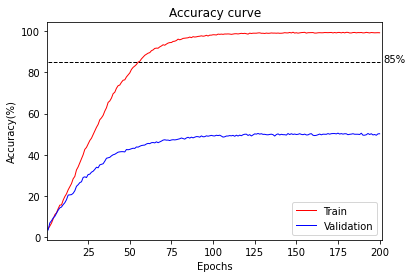

In [14]:
epoch = []
train_acc = []
val_acc = []
train_loss = []
val_loss = []

with open('./results/epoch_curve_plotting_data.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines, None)
    for row in lines:
        epoch.append(int(row[0]))
        train_acc.append(float(row[1])*100)
        train_loss.append(float(row[2]))
        val_acc.append(float(row[3])*100)
        val_loss.append(float(row[4]))

# plt accuracy curve
plt.figure()

plt.plot([1, 200.5], [85, 85], color='black', linestyle='dashed', lw=1)
plt.gca().text(202, 85, '85%', color='black')

plt.plot(epoch, train_acc, color = 'red', linewidth = '1', label = 'Train')
plt.plot(epoch, val_acc, color = 'blue', linewidth = '1', label = 'Validation')

plt.xlim(0.5, 201.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.title('Accuracy curve')
plt.legend(loc='lower right')

plt.savefig('./plots/acc_comparison(task3).png')
plt.show()

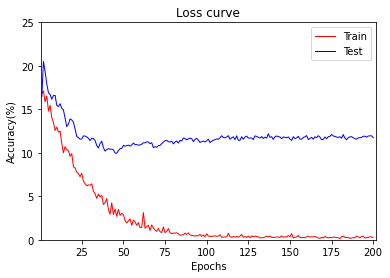

In [15]:
# plt loss curve
plt.figure()

plt.plot(epoch, train_loss, color = 'red', linewidth = '1', label = 'Train')
plt.plot(epoch, val_loss, color = 'blue', linewidth = '1', label = 'Test')

plt.xlim(0.5, 201.5)
plt.ylim(0, 25)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')

plt.title('Loss curve')
plt.legend(loc='upper right')

plt.savefig('./plots/loss_comparison(task3).png')
plt.show()